In [75]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import to_rgba
from pprint import pprint
import matplotlib.image as mpimg
import matplotlib.patches as patches
from io import BytesIO
import matplotlib as mpl
from matplotlib.gridspec import GridSpec
from matplotlib.markers import MarkerStyle
from mplsoccer import Pitch, VerticalPitch, FontManager, Sbopen, add_image
from matplotlib.font_manager import FontProperties
from matplotlib import rcParams
from matplotlib.patheffects import withStroke, Normal
from matplotlib.colors import LinearSegmentedColormap
from mplsoccer.utils import FontManager
import matplotlib.patheffects as path_effects
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib.cbook import get_sample_data
from sklearn.cluster import KMeans
import warnings
from highlight_text import ax_text, fig_text
from PIL import Image
from urllib.request import urlopen
import os
import time
from unidecode import unidecode
from scipy.spatial import ConvexHull

# Print the modified DataFrame
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# specify some custom colors to use
green = '#69f900'
red = '#ff4b44'
blue = '#00a0de'
violet = '#a369ff'
bg_color= '#f5f5f5'
line_color= '#000000'
# bg_color= '#000000'
# line_color= '#ffffff'
col1 = '#ff4b44'
col2 = '#00a0de'

In [77]:
df=pd.read_csv('E:\\Premier League DashBoard\\New folder\\Events\\Wolves vs Chelsea_EventsData.csv')
shots_df=pd.read_csv('E:\\Premier League DashBoard\\New folder\\Shots\\Wolves vs Chelsea_ShotsData.csv')

In [81]:
# Extract the part after 'Events\\'
file_pat='E:\\Premier League DashBoard\\New folder\\Events\\Wolves vs Chelsea_EventsData.csv'
relevant_part = file_pat.split('Events\\')[-1]

# Extract the file name from the relevant part
file_name = os.path.basename(relevant_part)

# Split file name to get team names
teams_part = file_name.split('_')[0]  # This gives 'Wolves vs Chelsea'
hteamName, ateamName = teams_part.split(' vs ')
print(hteamName,ateamName)

Wolves Chelsea


C:\Users\kevin\AppData\Local\Temp\ipykernel_12360\2601374328.py:100: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_passes_df['pass_or_carry_angle'] = team_passes_df['pass_or_carry_angle'].abs()
C:\Users\kevin\AppData\Local\Temp\ipykernel_12360\2601374328.py:100: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_passes_df['pass_or_carry_angle'] = team_passes_df['pass_or_carry_angle'].abs()


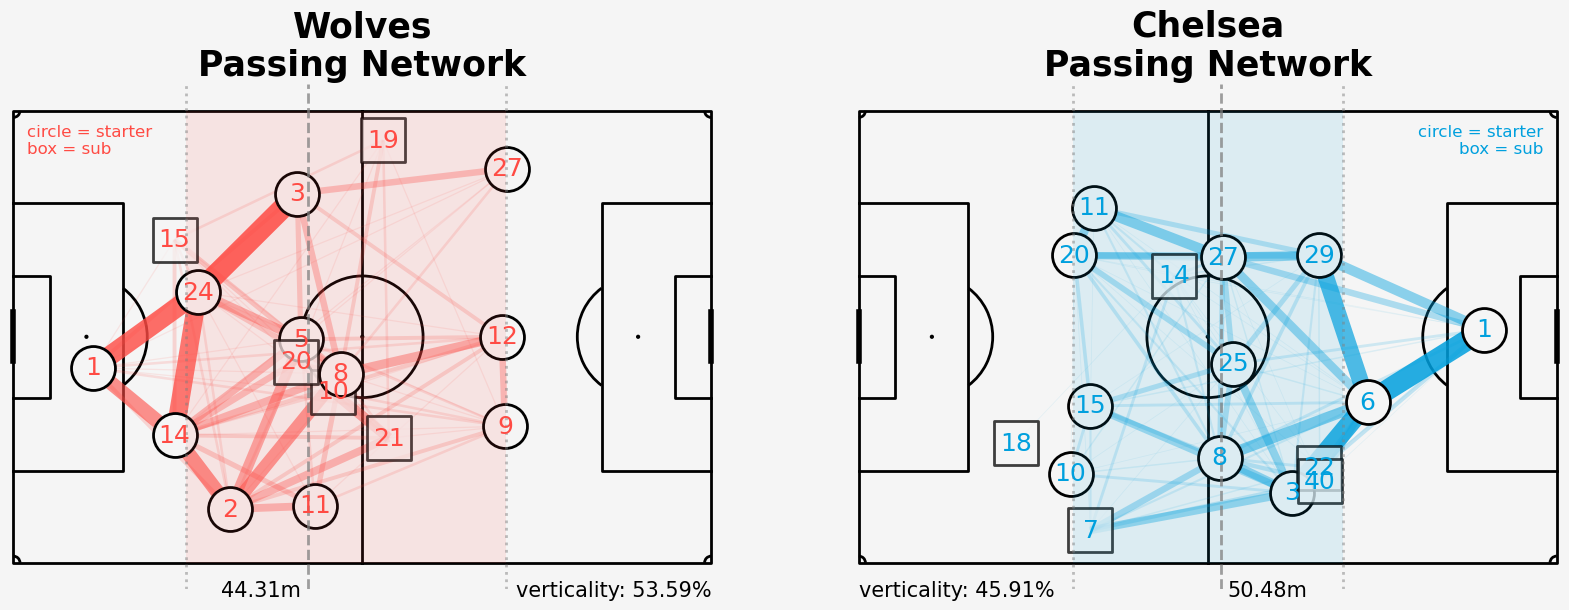

In [87]:
def get_passes_df(df):
    df1 = df[~df['type'].str.contains('SubstitutionOn|FormationChange|FormationSet|Card')]
    df = df1
    df.loc[:, "receiver"] = df["playerId"].shift(-1)
    passes_ids = df.index[df['type'] == 'Pass']
    df_passes = df.loc[passes_ids, ["index", "x", "y", "endX", "endY", "teamName", "playerId", "receiver", "type", "outcomeType", "pass_or_carry_angle"]]

    return df_passes
path_eff = [path_effects.Stroke(linewidth=3, foreground=bg_color), path_effects.Normal()]

players_df=pd.read_csv('PlayerData.csv')
def get_passes_between_df(teamName, passes_df, players_df):
    passes_df = passes_df[(passes_df["teamName"] == teamName)]
    # df = pd.DataFrame(events_dict)
    dfteam = df[(df['teamName'] == teamName) & (~df['type'].str.contains('SubstitutionOn|FormationChange|FormationSet|Card'))]
    passes_df = passes_df.merge(players_df[["playerId", "isFirstEleven"]], on='playerId', how='left')
    # calculate median positions for player's passes
    average_locs_and_count_df = (dfteam.groupby('playerId').agg({'x': ['median'], 'y': ['median', 'count']}))
    average_locs_and_count_df.columns = ['pass_avg_x', 'pass_avg_y', 'count']
    average_locs_and_count_df = average_locs_and_count_df.merge(players_df[['playerId', 'name', 'shirtNo', 'position', 'isFirstEleven']], on='playerId', how='left')
    average_locs_and_count_df = average_locs_and_count_df.set_index('playerId')
    average_locs_and_count_df['name'] = average_locs_and_count_df['name'].apply(unidecode)
    # calculate the number of passes between each position (using min/ max so we get passes both ways)
    passes_player_ids_df = passes_df.loc[:, ['index', 'playerId', 'receiver', 'teamName']]
    passes_player_ids_df['pos_max'] = (passes_player_ids_df[['playerId', 'receiver']].max(axis='columns'))
    passes_player_ids_df['pos_min'] = (passes_player_ids_df[['playerId', 'receiver']].min(axis='columns'))
    # get passes between each player
    passes_between_df = passes_player_ids_df.groupby(['pos_min', 'pos_max']).index.count().reset_index()
    passes_between_df.rename({'index': 'pass_count'}, axis='columns', inplace=True)
    # add on the location of each player so we have the start and end positions of the lines
    passes_between_df = passes_between_df.merge(average_locs_and_count_df, left_on='pos_min', right_index=True)
    passes_between_df = passes_between_df.merge(average_locs_and_count_df, left_on='pos_max', right_index=True, suffixes=['', '_end'])

    return passes_between_df, average_locs_and_count_df

# home_team_id = list(teams_dict.keys())[0]
home_passes_between_df, home_average_locs_and_count_df = get_passes_between_df(hteamName, passes_df, players_df)
# away_team_id = list(teams_dict.keys())[1]
away_passes_between_df, away_average_locs_and_count_df = get_passes_between_df(ateamName, passes_df, players_df)

def pass_network_visualization(ax, passes_between_df, average_locs_and_count_df, col, teamName, flipped=False):
    MAX_LINE_WIDTH = 15
    MAX_MARKER_SIZE = 3000
    passes_between_df['width'] = (passes_between_df.pass_count / passes_between_df.pass_count.max() *MAX_LINE_WIDTH)
    # average_locs_and_count_df['marker_size'] = (average_locs_and_count_df['count']/ average_locs_and_count_df['count'].max() * MAX_MARKER_SIZE) #You can plot variable size of each player's node according to their passing volume, in the plot using this
    MIN_TRANSPARENCY = 0.05
    MAX_TRANSPARENCY = 0.85
    color = np.array(to_rgba(col))
    color = np.tile(color, (len(passes_between_df), 1))
    c_transparency = passes_between_df.pass_count / passes_between_df.pass_count.max()
    c_transparency = (c_transparency * (MAX_TRANSPARENCY - MIN_TRANSPARENCY)) + MIN_TRANSPARENCY
    color[:, 3] = c_transparency

    pitch = Pitch(pitch_type='uefa', corner_arcs=True, pitch_color=bg_color, line_color=line_color, linewidth=2)
    pitch.draw(ax=ax)
    ax.set_xlim(-0.5, 105.5)
    # ax.set_ylim(-0.5, 68.5)

    # Plotting those lines between players
    pass_lines = pitch.lines(passes_between_df.pass_avg_x, passes_between_df.pass_avg_y, passes_between_df.pass_avg_x_end, passes_between_df.pass_avg_y_end,
                             lw=passes_between_df.width, color=color, zorder=1, ax=ax)

    # Plotting the player nodes
    for index, row in average_locs_and_count_df.iterrows():
      if row['isFirstEleven'] == True:
        pass_nodes = pitch.scatter(row['pass_avg_x'], row['pass_avg_y'], s=1000, marker='o', color=bg_color, edgecolor=line_color, linewidth=2, alpha=1, ax=ax)
      else:
        pass_nodes = pitch.scatter(row['pass_avg_x'], row['pass_avg_y'], s=1000, marker='s', color=bg_color, edgecolor=line_color, linewidth=2, alpha=0.75, ax=ax)

    # Plotting the shirt no. of each player
    for index, row in average_locs_and_count_df.iterrows():
        player_initials = row["shirtNo"]
        pitch.annotate(player_initials, xy=(row.pass_avg_x, row.pass_avg_y), c=col, ha='center', va='center', size=18, ax=ax)

    # Plotting a vertical line to show the median vertical position of all passes
    avgph = round(average_locs_and_count_df['pass_avg_x'].median(), 2)
    # avgph_show = round((avgph*1.05),2)
    avgph_show = avgph
    ax.axvline(x=avgph, color='gray', linestyle='--', alpha=0.75, linewidth=2)

    # Defense line Passing Height (avg. height of all the passes made by the Center Backs)
    center_backs_height = average_locs_and_count_df[average_locs_and_count_df['position']=='DC']
    def_line_h = round(center_backs_height['pass_avg_x'].median(), 2)
    ax.axvline(x=def_line_h, color='gray', linestyle='dotted', alpha=0.5, linewidth=2)
    
    # Forward line Passing Height (avg. height of all the passes made by the Top 2 avg positoned Forwards)
    Forwards_height = average_locs_and_count_df[average_locs_and_count_df['isFirstEleven']==1]
    Forwards_height = Forwards_height.sort_values(by='pass_avg_x', ascending=False)
    Forwards_height = Forwards_height.head(2)
    fwd_line_h = round(Forwards_height['pass_avg_x'].mean(), 2)
    ax.axvline(x=fwd_line_h, color='gray', linestyle='dotted', alpha=0.5, linewidth=2)
    
    # coloring the middle zone in the pitch
    ymid = [0, 0, 68, 68]
    xmid = [def_line_h, fwd_line_h, fwd_line_h, def_line_h]
    ax.fill(xmid, ymid, col, alpha=0.1)

    # Getting the verticality of a team, (Verticality means how straight forward a team passes while advancing the ball, more the value = more directness in forward passing)
    team_passes_df = passes_df[(passes_df["teamName"] == teamName)]
    team_passes_df['pass_or_carry_angle'] = team_passes_df['pass_or_carry_angle'].abs()
    team_passes_df = team_passes_df[(team_passes_df['pass_or_carry_angle']>=0) & (team_passes_df['pass_or_carry_angle']<=90)]
    med_ang = team_passes_df['pass_or_carry_angle'].median()
    verticality = round((1 - med_ang/90)*100, 2)

    # Getting the top passers combination
    passes_between_df = passes_between_df.sort_values(by='pass_count', ascending=False).head(1).reset_index(drop=True)
    most_pass_from = passes_between_df['name'][0]
    most_pass_to = passes_between_df['name_end'][0]
    most_pass_count = passes_between_df['pass_count'][0]
    
    # Heading and other texts
    if teamName == ateamName:
      # inverting the pitch for away team
      ax.invert_xaxis()
      ax.invert_yaxis()
      ax.text(avgph-1, 73, f"{avgph_show}m", fontsize=15, color=line_color, ha='left')
      ax.text(105, 73,f"verticality: {verticality}%", fontsize=15, color=line_color, ha='left')
    else:
      ax.text(avgph-1, -5, f"{avgph_show}m", fontsize=15, color=line_color, ha='right')
      ax.text(105, -5, f"verticality: {verticality}%", fontsize=15, color=line_color, ha='right')

    # Headlines and other texts
    if teamName == hteamName:
      ax.text(2,66, "circle = starter\nbox = sub", color=hcol, size=12, ha='left', va='top')
      ax.set_title(f"{hteamName}\nPassing Network", color=line_color, size=25, fontweight='bold')

    else:
      ax.text(2,2, "circle = starter\nbox = sub", color=acol, size=12, ha='right', va='top')
      ax.set_title(f"{ateamName}\nPassing Network", color=line_color, size=25, fontweight='bold')

    # returnig the stats for storing those 
    return {
        'Team_Name': teamName,
        'Defense_Line_Height': def_line_h,
        'Vericality_%': verticality,
        'Most_pass_combination_from': most_pass_from,
        'Most_pass_combination_to': most_pass_to,
        'Most_passes_in_combination': most_pass_count,
    } 

fig,axs=plt.subplots(1,2, figsize=(20,10), facecolor=bg_color)
pass_network_stats_home = pass_network_visualization(axs[0], home_passes_between_df, home_average_locs_and_count_df, hcol, hteamName)
pass_network_stats_away = pass_network_visualization(axs[1], away_passes_between_df, away_average_locs_and_count_df, acol, ateamName)
pass_network_stats_list = []
pass_network_stats_list.append(pass_network_stats_home)
pass_network_stats_list.append(pass_network_stats_away)
pass_network_stats_df = pd.DataFrame(pass_network_stats_list)

In [89]:
pass_network_stats_df

Team_Name  Defense_Line_Height  Vericality_% Most_pass_combination_from  \
0    Wolves                26.04         53.59            Rayan Ait-Nouri   
1   Chelsea                32.13         45.91             Robert Sanchez   

  Most_pass_combination_to  Most_passes_in_combination  
0               Toti Gomes                          16  
1             Levi Colwill                          29

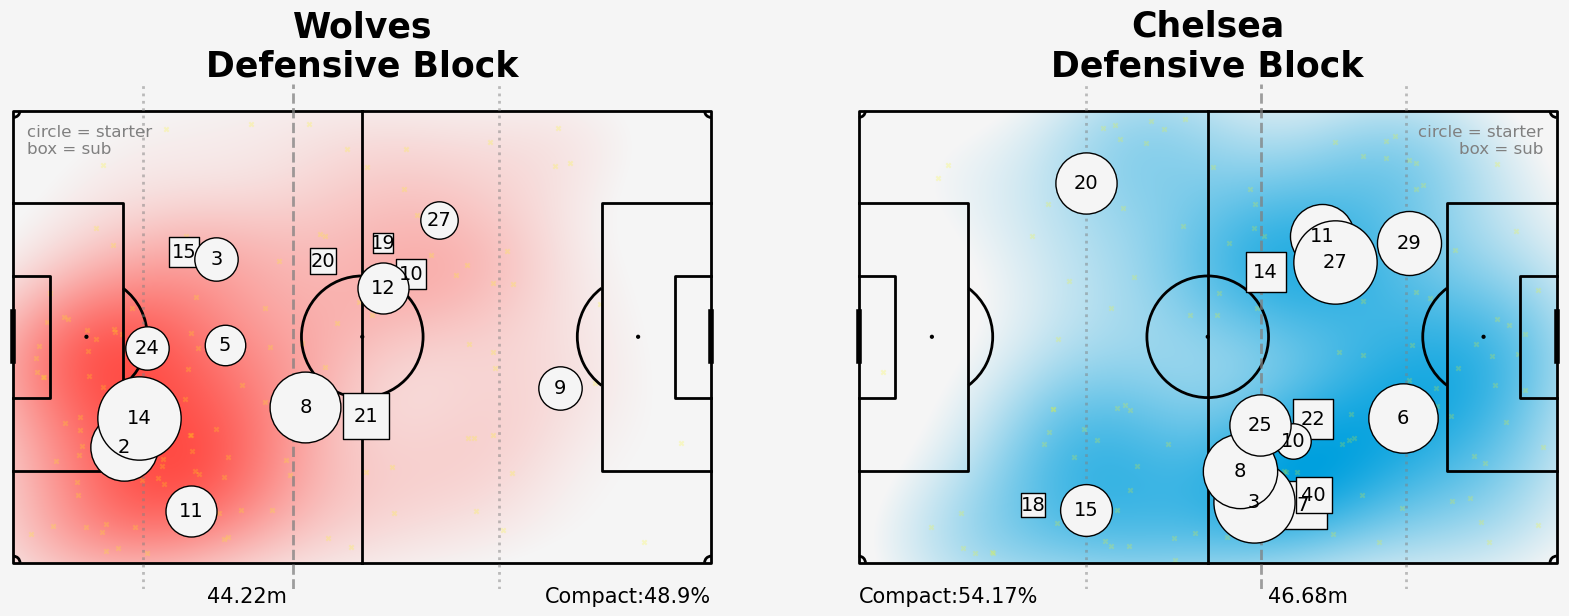

In [95]:
events_dict=df

def get_defensive_action_df(events_dict):
    # filter only defensive actions
    defensive_actions_ids = df.index[(df['type'] == 'Aerial') & (df['qualifiers'].str.contains('Defensive')) |
                                     (df['type'] == 'BallRecovery') |
                                     (df['type'] == 'BlockedPass') |
                                     (df['type'] == 'Challenge') |
                                     (df['type'] == 'Clearance') |
                                     (df['type'] == 'Error') |
                                     (df['type'] == 'Foul') |
                                     (df['type'] == 'Interception') |
                                     (df['type'] == 'Tackle')]
    df_defensive_actions = df.loc[defensive_actions_ids, ["index", "x", "y", "teamName", "playerId", "type", "outcomeType"]]

    return df_defensive_actions

defensive_actions_df = get_defensive_action_df(events_dict)

def get_da_count_df(team_name, defensive_actions_df, players_df):
    defensive_actions_df = defensive_actions_df[defensive_actions_df["teamName"] == team_name]
    # add column with first eleven players only
    defensive_actions_df = defensive_actions_df.merge(players_df[["playerId", "isFirstEleven"]], on='playerId', how='left')
    # calculate mean positions for players
    average_locs_and_count_df = (defensive_actions_df.groupby('playerId').agg({'x': ['median'], 'y': ['median', 'count']}))
    average_locs_and_count_df.columns = ['x', 'y', 'count']
    average_locs_and_count_df = average_locs_and_count_df.merge(players_df[['playerId', 'name', 'shirtNo', 'position', 'isFirstEleven']], on='playerId', how='left')
    average_locs_and_count_df = average_locs_and_count_df.set_index('playerId')

    return  average_locs_and_count_df

defensive_home_average_locs_and_count_df = get_da_count_df(hteamName, defensive_actions_df, players_df)
defensive_away_average_locs_and_count_df = get_da_count_df(ateamName, defensive_actions_df, players_df)
defensive_home_average_locs_and_count_df = defensive_home_average_locs_and_count_df[defensive_home_average_locs_and_count_df['position'] != 'GK']
defensive_away_average_locs_and_count_df = defensive_away_average_locs_and_count_df[defensive_away_average_locs_and_count_df['position'] != 'GK']

def defensive_block(ax, average_locs_and_count_df, team_name, col):
    defensive_actions_team_df = defensive_actions_df[defensive_actions_df["teamName"] == team_name]
    pitch = Pitch(pitch_type='uefa', pitch_color=bg_color, line_color=line_color, linewidth=2, line_zorder=2, corner_arcs=True)
    pitch.draw(ax=ax)
    ax.set_facecolor(bg_color)
    ax.set_xlim(-0.5, 105.5)
    # ax.set_ylim(-0.5, 68.5)

    # using variable marker size for each player according to their defensive engagements
    MAX_MARKER_SIZE = 3500
    average_locs_and_count_df['marker_size'] = (average_locs_and_count_df['count']/ average_locs_and_count_df['count'].max() * MAX_MARKER_SIZE)
    # plotting the heatmap of the team defensive actions
    color = np.array(to_rgba(col))
    flamingo_cmap = LinearSegmentedColormap.from_list("Flamingo - 100 colors", [bg_color, col], N=500)
    kde = pitch.kdeplot(defensive_actions_team_df.x, defensive_actions_team_df.y, ax=ax, fill=True, levels=5000, thresh=0.02, cut=4, cmap=flamingo_cmap)

    # using different node marker for starting and substitute players
    average_locs_and_count_df = average_locs_and_count_df.reset_index(drop=True)
    for index, row in average_locs_and_count_df.iterrows():
        if row['isFirstEleven'] == True:
            da_nodes = pitch.scatter(row['x'], row['y'], s=row['marker_size']+100, marker='o', color=bg_color, edgecolor=line_color, linewidth=1, 
                                 alpha=1, zorder=3, ax=ax)
        else:
            da_nodes = pitch.scatter(row['x'], row['y'], s=row['marker_size']+100, marker='s', color=bg_color, edgecolor=line_color, linewidth=1, 
                                     alpha=1, zorder=3, ax=ax)
    # plotting very tiny scatterings for the defensive actions
    da_scatter = pitch.scatter(defensive_actions_team_df.x, defensive_actions_team_df.y, s=10, marker='x', color='yellow', alpha=0.2, ax=ax)

    # Plotting the shirt no. of each player
    for index, row in average_locs_and_count_df.iterrows():
        player_initials = row["shirtNo"]
        pitch.annotate(player_initials, xy=(row.x, row.y), c=line_color, ha='center', va='center', size=(14), ax=ax)

    # Plotting a vertical line to show the median vertical position of all defensive actions, which is called Defensive Actions Height
    dah = round(average_locs_and_count_df['x'].mean(), 2)
    dah_show = round((dah*1.05), 2)
    ax.axvline(x=dah, color='gray', linestyle='--', alpha=0.75, linewidth=2)

    # Defense line Defensive Actions Height
    center_backs_height = average_locs_and_count_df[average_locs_and_count_df['position']=='DC']
    def_line_h = round(center_backs_height['x'].median(), 2)
    ax.axvline(x=def_line_h, color='gray', linestyle='dotted', alpha=0.5, linewidth=2)
    # Forward line Defensive Actions Height
    Forwards_height = average_locs_and_count_df[average_locs_and_count_df['isFirstEleven']==1]
    Forwards_height = Forwards_height.sort_values(by='x', ascending=False)
    Forwards_height = Forwards_height.head(2)
    fwd_line_h = round(Forwards_height['x'].mean(), 2)
    ax.axvline(x=fwd_line_h, color='gray', linestyle='dotted', alpha=0.5, linewidth=2)

    # Getting the compactness value 
    compactness = round((1 - ((fwd_line_h - def_line_h) / 105)) * 100, 2)

    # Headings and other texts
    if team_name == ateamName:
        # inverting the axis for away team
        ax.invert_xaxis()
        ax.invert_yaxis()
        ax.text(dah-1, 73, f"{dah_show}m", fontsize=15, color=line_color, ha='left', va='center')
    else:
        ax.text(dah-1, -5, f"{dah_show}m", fontsize=15, color=line_color, ha='right', va='center')

    # Headlines and other texts
    if team_name == hteamName:
        ax.text(105, -5, f'Compact:{compactness}%', fontsize=15, color=line_color, ha='right', va='center')
        ax.text(2,66, "circle = starter\nbox = sub", color='gray', size=12, ha='left', va='top')
        ax.set_title(f"{hteamName}\nDefensive Block", color=line_color, fontsize=25, fontweight='bold')
    else:
        ax.text(105, 73, f'Compact:{compactness}%', fontsize=15, color=line_color, ha='left', va='center')
        ax.text(2,2, "circle = starter\nbox = sub", color='gray', size=12, ha='right', va='top')
        ax.set_title(f"{ateamName}\nDefensive Block", color=line_color, fontsize=25, fontweight='bold')

    return {
        'Team_Name': team_name,
        'Average_Defensive_Action_Height': dah,
        'Forward_Line_Pressing_Height': fwd_line_h
    }

fig,axs=plt.subplots(1,2, figsize=(20,10), facecolor=bg_color)
defensive_block_stats_home = defensive_block(axs[0], defensive_home_average_locs_and_count_df, hteamName, hcol)
defensive_block_stats_away = defensive_block(axs[1], defensive_away_average_locs_and_count_df, ateamName, acol)
defensive_block_stats_list = []
defensive_block_stats_list.append(defensive_block_stats_home)
defensive_block_stats_list.append(defensive_block_stats_away)
defensive_block_stats_df = pd.DataFrame(defensive_block_stats_list)

In [97]:
defensive_block_stats_df

Team_Name  Average_Defensive_Action_Height  Forward_Line_Pressing_Height
0    Wolves                            42.11                         73.13
1   Chelsea                            44.46                         70.80

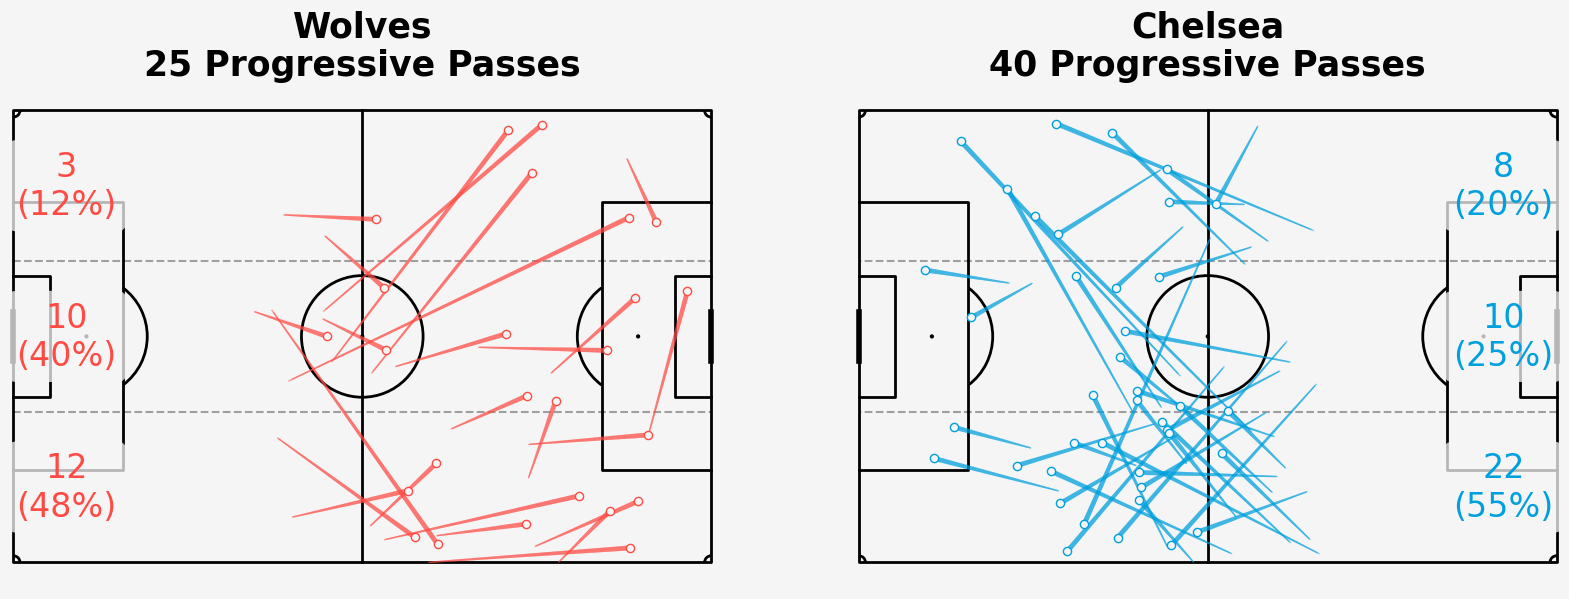

In [99]:
def draw_progressive_pass_map(ax, team_name, col):
    # filtering those passes which has reduced the distance form goal for at least 10yds and not started from defensive third, this is my condition for a progressive pass, which almost similar to opta/statsbomb conditon
    dfpro = df[(df['teamName']==team_name) & (df['prog_pass']>=9.11) & (~df['qualifiers'].str.contains('CornerTaken|Freekick')) & 
               (df['x']>=35) & (df['outcomeType']=='Successful')]
    pitch = Pitch(pitch_type='uefa', pitch_color=bg_color, line_color=line_color, linewidth=2, corner_arcs=True)
    pitch.draw(ax=ax)
    ax.set_xlim(-0.5, 105.5)
    # ax.set_ylim(-0.5, 68.5)

    if team_name == ateamName:
        ax.invert_xaxis()
        ax.invert_yaxis()

    pro_count = len(dfpro)

    # calculating the counts
    left_pro = len(dfpro[dfpro['y']>=45.33])
    mid_pro = len(dfpro[(dfpro['y']>=22.67) & (dfpro['y']<45.33)])
    right_pro = len(dfpro[(dfpro['y']>=0) & (dfpro['y']<22.67)])
    left_percentage = round((left_pro/pro_count)*100)
    mid_percentage = round((mid_pro/pro_count)*100)
    right_percentage = round((right_pro/pro_count)*100)

    ax.hlines(22.67, xmin=0, xmax=105, colors=line_color, linestyle='dashed', alpha=0.35)
    ax.hlines(45.33, xmin=0, xmax=105, colors=line_color, linestyle='dashed', alpha=0.35)

    # showing the texts in the pitch
    bbox_props = dict(boxstyle="round,pad=0.3", edgecolor="None", facecolor=bg_color, alpha=0.75)
    if col == hcol:
        ax.text(8, 11.335, f'{right_pro}\n({right_percentage}%)', color=hcol, fontsize=24, va='center', ha='center', bbox=bbox_props)
        ax.text(8, 34, f'{mid_pro}\n({mid_percentage}%)', color=hcol, fontsize=24, va='center', ha='center', bbox=bbox_props)
        ax.text(8, 56.675, f'{left_pro}\n({left_percentage}%)', color=hcol, fontsize=24, va='center', ha='center', bbox=bbox_props)
    else:
        ax.text(8, 11.335, f'{right_pro}\n({right_percentage}%)', color=acol, fontsize=24, va='center', ha='center', bbox=bbox_props)
        ax.text(8, 34, f'{mid_pro}\n({mid_percentage}%)', color=acol, fontsize=24, va='center', ha='center', bbox=bbox_props)
        ax.text(8, 56.675, f'{left_pro}\n({left_percentage}%)', color=acol, fontsize=24, va='center', ha='center', bbox=bbox_props)

    # plotting the passes
    pro_pass = pitch.lines(dfpro.x, dfpro.y, dfpro.endX, dfpro.endY, lw=3.5, comet=True, color=col, ax=ax, alpha=0.5)
    # plotting some scatters at the end of each pass
    pro_pass_end = pitch.scatter(dfpro.endX, dfpro.endY, s=35, edgecolor=col, linewidth=1, color=bg_color, zorder=2, ax=ax)

    counttext = f"{pro_count} Progressive Passes"

    # Heading and other texts
    if col == hcol:
        ax.set_title(f"{hteamName}\n{counttext}", color=line_color, fontsize=25, fontweight='bold')
    else:
        ax.set_title(f"{ateamName}\n{counttext}", color=line_color, fontsize=25, fontweight='bold')

    return {
        'Team_Name': team_name,
        'Total_Progressive_Passes': pro_count,
        'Progressive_Passes_From_Left': left_pro,
        'Progressive_Passes_From_Center': mid_pro,
        'Progressive_Passes_From_Right': right_pro
    }

fig,axs=plt.subplots(1,2, figsize=(20,10), facecolor=bg_color)
Progressvie_Passes_Stats_home = draw_progressive_pass_map(axs[0], hteamName, hcol)
Progressvie_Passes_Stats_away = draw_progressive_pass_map(axs[1], ateamName, acol)
Progressvie_Passes_Stats_list = []
Progressvie_Passes_Stats_list.append(Progressvie_Passes_Stats_home)
Progressvie_Passes_Stats_list.append(Progressvie_Passes_Stats_away)
Progressvie_Passes_Stats_df = pd.DataFrame(Progressvie_Passes_Stats_list)

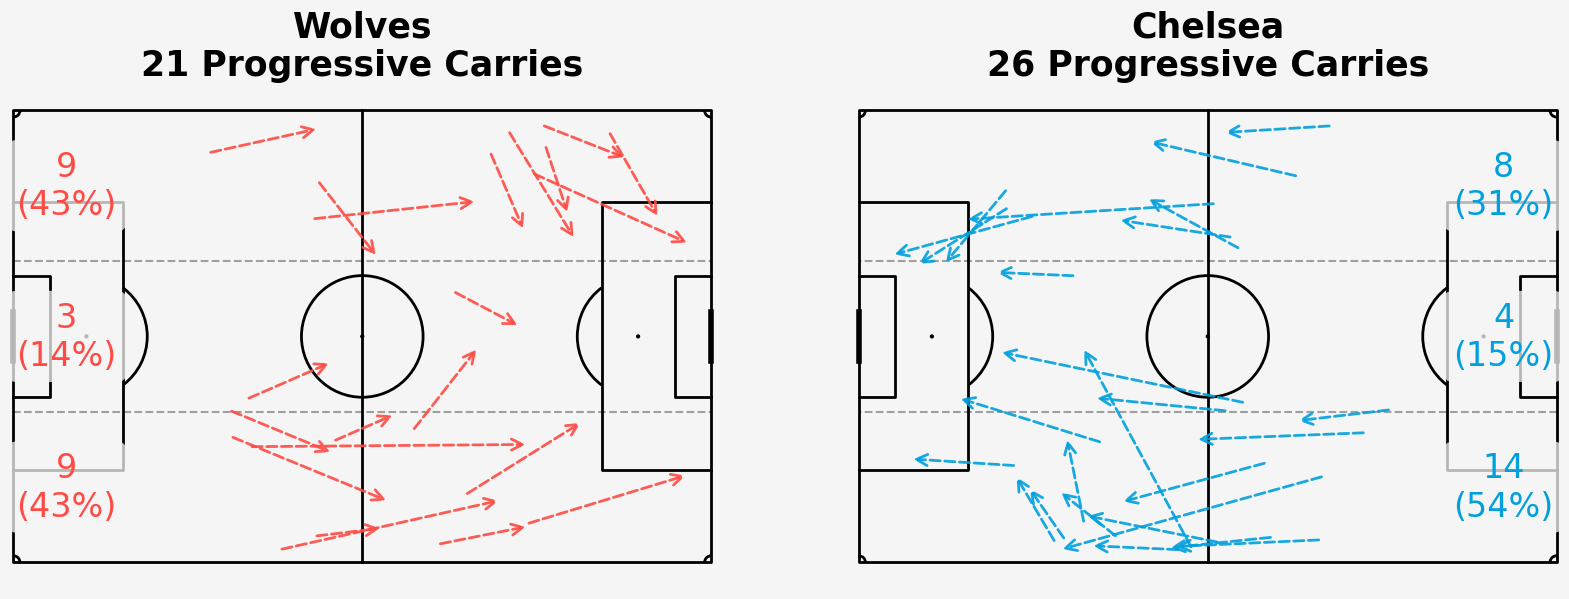

In [101]:
def draw_progressive_carry_map(ax, team_name, col):
    # filtering those carries which has reduced the distance form goal for at least 10yds and not ended at defensive third, this is my condition for a progressive pass, which almost similar to opta/statsbomb conditon
    dfpro = df[(df['teamName']==team_name) & (df['prog_carry']>=9.11) & (df['endX']>=35)]
    pitch = Pitch(pitch_type='uefa', pitch_color=bg_color, line_color=line_color, linewidth=2,
                          corner_arcs=True)
    pitch.draw(ax=ax)
    ax.set_xlim(-0.5, 105.5)
    # ax.set_ylim(-5, 68.5)

    if team_name == ateamName:
        ax.invert_xaxis()
        ax.invert_yaxis()

    pro_count = len(dfpro)

    # calculating the counts
    left_pro = len(dfpro[dfpro['y']>=45.33])
    mid_pro = len(dfpro[(dfpro['y']>=22.67) & (dfpro['y']<45.33)])
    right_pro = len(dfpro[(dfpro['y']>=0) & (dfpro['y']<22.67)])
    left_percentage = round((left_pro/pro_count)*100)
    mid_percentage = round((mid_pro/pro_count)*100)
    right_percentage = round((right_pro/pro_count)*100)

    ax.hlines(22.67, xmin=0, xmax=105, colors=line_color, linestyle='dashed', alpha=0.35)
    ax.hlines(45.33, xmin=0, xmax=105, colors=line_color, linestyle='dashed', alpha=0.35)

    # showing the texts in the pitch
    bbox_props = dict(boxstyle="round,pad=0.3", edgecolor="None", facecolor=bg_color, alpha=0.75)
    if col == hcol:
        ax.text(8, 11.335, f'{right_pro}\n({right_percentage}%)', color=hcol, fontsize=24, va='center', ha='center', bbox=bbox_props)
        ax.text(8, 34, f'{mid_pro}\n({mid_percentage}%)', color=hcol, fontsize=24, va='center', ha='center', bbox=bbox_props)
        ax.text(8, 56.675, f'{left_pro}\n({left_percentage}%)', color=hcol, fontsize=24, va='center', ha='center', bbox=bbox_props)
    else:
        ax.text(8, 11.335, f'{right_pro}\n({right_percentage}%)', color=acol, fontsize=24, va='center', ha='center', bbox=bbox_props)
        ax.text(8, 34, f'{mid_pro}\n({mid_percentage}%)', color=acol, fontsize=24, va='center', ha='center', bbox=bbox_props)
        ax.text(8, 56.675, f'{left_pro}\n({left_percentage}%)', color=acol, fontsize=24, va='center', ha='center', bbox=bbox_props)

    # plotting the carries
    for index, row in dfpro.iterrows():
        arrow = patches.FancyArrowPatch((row['x'], row['y']), (row['endX'], row['endY']), arrowstyle='->', color=col, zorder=4, mutation_scale=20, 
                                        alpha=0.9, linewidth=2, linestyle='--')
        ax.add_patch(arrow)

    counttext = f"{pro_count} Progressive Carries"

    # Heading and other texts
    if col == hcol:
        ax.set_title(f"{hteamName}\n{counttext}", color=line_color, fontsize=25, fontweight='bold')
    else:
        ax.set_title(f"{ateamName}\n{counttext}", color=line_color, fontsize=25, fontweight='bold')

    return {
        'Team_Name': team_name,
        'Total_Progressive_Carries': pro_count,
        'Progressive_Carries_From_Left': left_pro,
        'Progressive_Carries_From_Center': mid_pro,
        'Progressive_Carries_From_Right': right_pro
    }

fig,axs=plt.subplots(1,2, figsize=(20,10), facecolor=bg_color)
Progressvie_Carries_Stats_home = draw_progressive_carry_map(axs[0], hteamName, hcol)
Progressvie_Carries_Stats_away = draw_progressive_carry_map(axs[1], ateamName, acol)
Progressvie_Carries_Stats_list = []
Progressvie_Carries_Stats_list.append(Progressvie_Carries_Stats_home)
Progressvie_Carries_Stats_list.append(Progressvie_Carries_Stats_away)
Progressvie_Carries_Stats_df = pd.DataFrame(Progressvie_Carries_Stats_list)

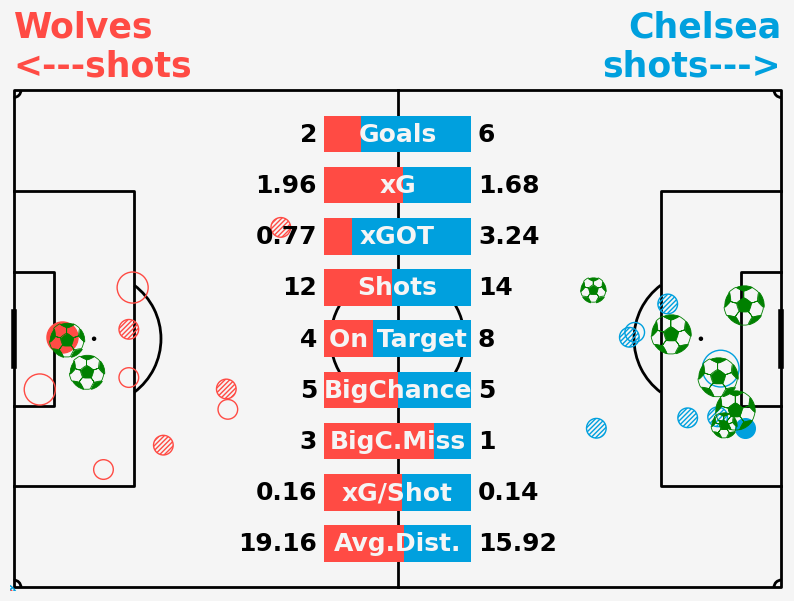

In [109]:
homedf = df[(df['teamName']==hteamName)]
awaydf = df[(df['teamName']==ateamName)]
hxT = homedf['xT'].sum().round(2)
axT = awaydf['xT'].sum().round(2)


# Getting the Score of the match
hgoal_count = len(homedf[(homedf['teamName']==hteamName) & (homedf['type']=='Goal') & (~homedf['qualifiers'].str.contains('OwnGoal'))])
agoal_count = len(awaydf[(awaydf['teamName']==ateamName) & (awaydf['type']=='Goal') & (~awaydf['qualifiers'].str.contains('OwnGoal'))])
hgoal_count = hgoal_count + len(awaydf[(awaydf['teamName']==ateamName) & (awaydf['type']=='Goal') & (awaydf['qualifiers'].str.contains('OwnGoal'))])
agoal_count = agoal_count + len(homedf[(homedf['teamName']==hteamName) & (homedf['type']=='Goal') & (homedf['qualifiers'].str.contains('OwnGoal'))])

hshots_xgdf = shots_df[shots_df['teamName']==hteamName]
ashots_xgdf = shots_df[shots_df['teamName']==ateamName]
hxg = round(hshots_xgdf['expectedGoals'].sum(), 2)
axg = round(ashots_xgdf['expectedGoals'].sum(), 2)
hxgot = round(hshots_xgdf['expectedGoalsOnTarget'].sum(), 2)
axgot = round(ashots_xgdf['expectedGoalsOnTarget'].sum(), 2)


# filtering the shots only
mask4 = (df['type'] == 'Goal') | (df['type'] == 'MissedShots') | (df['type'] == 'SavedShot') | (df['type'] == 'ShotOnPost')
Shotsdf = df[mask4]
Shotsdf.reset_index(drop=True, inplace=True)

# filtering according to the types of shots
hShotsdf = Shotsdf[Shotsdf['teamName']==hteamName]
aShotsdf = Shotsdf[Shotsdf['teamName']==ateamName]
hSavedf = hShotsdf[(hShotsdf['type']=='SavedShot') & (~hShotsdf['qualifiers'].str.contains(': 82,'))]
aSavedf = aShotsdf[(aShotsdf['type']=='SavedShot') & (~aShotsdf['qualifiers'].str.contains(': 82,'))]
hogdf = hShotsdf[(hShotsdf['teamName']==hteamName) & (hShotsdf['qualifiers'].str.contains('OwnGoal'))]
aogdf = aShotsdf[(aShotsdf['teamName']==ateamName) & (aShotsdf['qualifiers'].str.contains('OwnGoal'))]

#shooting stats
hTotalShots = len(hShotsdf)
aTotalShots = len(aShotsdf)
hShotsOnT = len(hSavedf) + hgoal_count
aShotsOnT = len(aSavedf) + agoal_count
hxGpSh = round(hxg/hTotalShots, 2)
axGpSh = round(axg/hTotalShots, 2)
# Center Goal point
given_point = (105, 34)
# Calculate shot distances
home_shot_distances = np.sqrt((hShotsdf['x'] - given_point[0])**2 + (hShotsdf['y'] - given_point[1])**2)
home_average_shot_distance = round(home_shot_distances.mean(),2)
away_shot_distances = np.sqrt((aShotsdf['x'] - given_point[0])**2 + (aShotsdf['y'] - given_point[1])**2)
away_average_shot_distance = round(away_shot_distances.mean(),2)

def plot_shotmap(ax):
    pitch = Pitch(pitch_type='uefa', corner_arcs=True, pitch_color=bg_color, linewidth=2, line_color=line_color)
    pitch.draw(ax=ax)
    ax.set_ylim(-0.5,68.5)
    ax.set_xlim(-0.5,105.5)
    # without big chances for home team
    hGoalData = Shotsdf[(Shotsdf['teamName'] == hteamName) & (Shotsdf['type'] == 'Goal') & (~Shotsdf['qualifiers'].str.contains('BigChance'))]
    hPostData = Shotsdf[(Shotsdf['teamName'] == hteamName) & (Shotsdf['type'] == 'ShotOnPost') & (~Shotsdf['qualifiers'].str.contains('BigChance'))]
    hSaveData = Shotsdf[(Shotsdf['teamName'] == hteamName) & (Shotsdf['type'] == 'SavedShot') & (~Shotsdf['qualifiers'].str.contains('BigChance'))]
    hMissData = Shotsdf[(Shotsdf['teamName'] == hteamName) & (Shotsdf['type'] == 'MissedShots') & (~Shotsdf['qualifiers'].str.contains('BigChance'))]
    # only big chances of home team
    Big_C_hGoalData = Shotsdf[(Shotsdf['teamName'] == hteamName) & (Shotsdf['type'] == 'Goal') & (Shotsdf['qualifiers'].str.contains('BigChance'))]
    Big_C_hPostData = Shotsdf[(Shotsdf['teamName'] == hteamName) & (Shotsdf['type'] == 'ShotOnPost') & (Shotsdf['qualifiers'].str.contains('BigChance'))]
    Big_C_hSaveData = Shotsdf[(Shotsdf['teamName'] == hteamName) & (Shotsdf['type'] == 'SavedShot') & (Shotsdf['qualifiers'].str.contains('BigChance'))]
    Big_C_hMissData = Shotsdf[(Shotsdf['teamName'] == hteamName) & (Shotsdf['type'] == 'MissedShots') & (Shotsdf['qualifiers'].str.contains('BigChance'))]
    total_bigC_home = len(Big_C_hGoalData) + len(Big_C_hPostData) + len(Big_C_hSaveData) + len(Big_C_hMissData)
    bigC_miss_home = len(Big_C_hPostData) + len(Big_C_hSaveData) + len(Big_C_hMissData)
    # normal shots scatter of home team
    sc2 = pitch.scatter((105-hPostData.x), (68-hPostData.y), s=200, edgecolors=hcol, c=hcol, marker='o', ax=ax)
    sc3 = pitch.scatter((105-hSaveData.x), (68-hSaveData.y), s=200, edgecolors=hcol, c='None', hatch='///////', marker='o', ax=ax)
    sc4 = pitch.scatter((105-hMissData.x), (68-hMissData.y), s=200, edgecolors=hcol, c='None', marker='o', ax=ax)
    sc1 = pitch.scatter((105-hGoalData.x), (68-hGoalData.y), s=350, edgecolors='green', linewidths=0.6, c='None', marker='football', zorder=3, ax=ax)
    sc1_og = pitch.scatter((105-hogdf.x), (68-hogdf.y), s=350, edgecolors='orange', linewidths=0.6, c='None', marker='football', zorder=3, ax=ax)
    # big chances bigger scatter of home team
    bc_sc2 = pitch.scatter((105-Big_C_hPostData.x), (68-Big_C_hPostData.y), s=500, edgecolors=hcol, c=hcol, marker='o', ax=ax)
    bc_sc3 = pitch.scatter((105-Big_C_hSaveData.x), (68-Big_C_hSaveData.y), s=500, edgecolors=hcol, c='None', hatch='///////', marker='o', ax=ax)
    bc_sc4 = pitch.scatter((105-Big_C_hMissData.x), (68-Big_C_hMissData.y), s=500, edgecolors=hcol, c='None', marker='o', ax=ax)
    bc_sc1 = pitch.scatter((105-Big_C_hGoalData.x), (68-Big_C_hGoalData.y), s=650, edgecolors='green', linewidths=0.6, c='None', marker='football', ax=ax)

    # without big chances for away team
    aGoalData = Shotsdf[(Shotsdf['teamName'] == ateamName) & (Shotsdf['type'] == 'Goal') & (~Shotsdf['qualifiers'].str.contains('BigChance'))]
    aPostData = Shotsdf[(Shotsdf['teamName'] == ateamName) & (Shotsdf['type'] == 'ShotOnPost') & (~Shotsdf['qualifiers'].str.contains('BigChance'))]
    aSaveData = Shotsdf[(Shotsdf['teamName'] == ateamName) & (Shotsdf['type'] == 'SavedShot') & (~Shotsdf['qualifiers'].str.contains('BigChance'))]
    aMissData = Shotsdf[(Shotsdf['teamName'] == ateamName) & (Shotsdf['type'] == 'MissedShots') & (~Shotsdf['qualifiers'].str.contains('BigChance'))]
    # only big chances of away team
    Big_C_aGoalData = Shotsdf[(Shotsdf['teamName'] == ateamName) & (Shotsdf['type'] == 'Goal') & (Shotsdf['qualifiers'].str.contains('BigChance'))]
    Big_C_aPostData = Shotsdf[(Shotsdf['teamName'] == ateamName) & (Shotsdf['type'] == 'ShotOnPost') & (Shotsdf['qualifiers'].str.contains('BigChance'))]
    Big_C_aSaveData = Shotsdf[(Shotsdf['teamName'] == ateamName) & (Shotsdf['type'] == 'SavedShot') & (Shotsdf['qualifiers'].str.contains('BigChance'))]
    Big_C_aMissData = Shotsdf[(Shotsdf['teamName'] == ateamName) & (Shotsdf['type'] == 'MissedShots') & (Shotsdf['qualifiers'].str.contains('BigChance'))]
    total_bigC_away = len(Big_C_aGoalData) + len(Big_C_aPostData) + len(Big_C_aSaveData) + len(Big_C_aMissData)
    bigC_miss_away = len(Big_C_aPostData) + len(Big_C_aSaveData) + len(Big_C_aMissData)
    # normal shots scatter of away team
    sc6 = pitch.scatter(aPostData.x, aPostData.y, s=200, edgecolors=acol, c=acol, marker='o', ax=ax)
    sc7 = pitch.scatter(aSaveData.x, aSaveData.y, s=200, edgecolors=acol, c='None', hatch='///////', marker='o', ax=ax)
    sc8 = pitch.scatter(aMissData.x, aMissData.y, s=200, edgecolors=acol, c='None', marker='o', ax=ax)
    sc5 = pitch.scatter(aGoalData.x, aGoalData.y, s=350, edgecolors='green', linewidths=0.6, c='None', marker='football', zorder=3, ax=ax)
    sc5_og = pitch.scatter((aogdf.x), (aogdf.y), s=350, edgecolors='orange', linewidths=0.6, c='None', marker='football', zorder=3, ax=ax)
    # big chances bigger scatter of away team
    bc_sc6 = pitch.scatter(Big_C_aPostData.x, Big_C_aPostData.y, s=700, edgecolors=acol, c=acol, marker='o', ax=ax)
    bc_sc7 = pitch.scatter(Big_C_aSaveData.x, Big_C_aSaveData.y, s=700, edgecolors=acol, c='None', hatch='///////', marker='o', ax=ax)
    bc_sc8 = pitch.scatter(Big_C_aMissData.x, Big_C_aMissData.y, s=700, edgecolors=acol, c='None', marker='o', ax=ax)
    bc_sc5 = pitch.scatter(Big_C_aGoalData.x, Big_C_aGoalData.y, s=850, edgecolors='green', linewidths=0.6, c='None', marker='football', ax=ax)

    # Stats bar diagram
    shooting_stats_title = [62, 62-(1*7), 62-(2*7), 62-(3*7), 62-(4*7), 62-(5*7), 62-(6*7), 62-(7*7), 62-(8*7)]
    shooting_stats_home = [hgoal_count, hxg, hxgot, hTotalShots, hShotsOnT, hxGpSh, total_bigC_home, bigC_miss_home, home_average_shot_distance]
    shooting_stats_away = [agoal_count, axg, axgot, aTotalShots, aShotsOnT, axGpSh, total_bigC_away, bigC_miss_away, away_average_shot_distance]

    # sometimes the both teams ends the match 0-0, then normalizing the data becomes problem, thats why this part of the code
    if hgoal_count+agoal_count == 0:
       hgoal = 10
       agoal = 10
    else:
       hgoal = (hgoal_count/(hgoal_count+agoal_count))*20
       agoal = (agoal_count/(hgoal_count+agoal_count))*20
        
    if total_bigC_home+total_bigC_away == 0:
       total_bigC_home = 10
       total_bigC_away = 10
        
    if bigC_miss_home+bigC_miss_away == 0:
       bigC_miss_home = 10
       bigC_miss_away = 10

    # normalizing the stats
    shooting_stats_normalized_home = [hgoal, (hxg/(hxg+axg))*20, (hxgot/(hxgot+axgot))*20,
                                      (hTotalShots/(hTotalShots+aTotalShots))*20, (hShotsOnT/(hShotsOnT+aShotsOnT))*20,
                                      (total_bigC_home/(total_bigC_home+total_bigC_away))*20, (bigC_miss_home/(bigC_miss_home+bigC_miss_away))*20,
                                      (hxGpSh/(hxGpSh+axGpSh))*20, 
                                      (home_average_shot_distance/(home_average_shot_distance+away_average_shot_distance))*20]
    shooting_stats_normalized_away = [agoal, (axg/(hxg+axg))*20, (axgot/(hxgot+axgot))*20,
                                      (aTotalShots/(hTotalShots+aTotalShots))*20, (aShotsOnT/(hShotsOnT+aShotsOnT))*20,
                                      (total_bigC_away/(total_bigC_home+total_bigC_away))*20, (bigC_miss_away/(bigC_miss_home+bigC_miss_away))*20,
                                      (axGpSh/(hxGpSh+axGpSh))*20,
                                      (away_average_shot_distance/(home_average_shot_distance+away_average_shot_distance))*20]

    # definig the start point
    start_x = 42.5
    start_x_for_away = [x + 42.5 for x in shooting_stats_normalized_home]
    ax.barh(shooting_stats_title, shooting_stats_normalized_home, height=5, color=hcol, left=start_x)
    ax.barh(shooting_stats_title, shooting_stats_normalized_away, height=5, left=start_x_for_away, color=acol)
    # Turn off axis-related elements
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False)
    ax.set_xticks([])
    ax.set_yticks([])

    # plotting the texts
    ax.text(52.5, 62, "Goals", color=bg_color, fontsize=18, ha='center', va='center', fontweight='bold')
    ax.text(52.5, 62-(1*7), "xG", color=bg_color, fontsize=18, ha='center', va='center', fontweight='bold')
    ax.text(52.5, 62-(2*7), "xGOT", color=bg_color, fontsize=18, ha='center', va='center', fontweight='bold')
    ax.text(52.5, 62-(3*7), "Shots", color=bg_color, fontsize=18, ha='center', va='center', fontweight='bold')
    ax.text(52.5, 62-(4*7), "On Target", color=bg_color, fontsize=18, ha='center', va='center', fontweight='bold')
    ax.text(52.5, 62-(5*7), "BigChance", color=bg_color, fontsize=18, ha='center', va='center', fontweight='bold')
    ax.text(52.5, 62-(6*7), "BigC.Miss", color=bg_color, fontsize=18, ha='center', va='center', fontweight='bold')
    ax.text(52.5, 62-(7*7), "xG/Shot", color=bg_color, fontsize=18, ha='center', va='center', fontweight='bold')
    ax.text(52.5, 62-(8*7), "Avg.Dist.", color=bg_color, fontsize=18, ha='center', va='center', fontweight='bold')

    ax.text(41.5, 62, f"{hgoal_count}", color=line_color, fontsize=18, ha='right', va='center', fontweight='bold')
    ax.text(41.5, 62-(1*7), f"{hxg}", color=line_color, fontsize=18, ha='right', va='center', fontweight='bold')
    ax.text(41.5, 62-(2*7), f"{hxgot}", color=line_color, fontsize=18, ha='right', va='center', fontweight='bold')
    ax.text(41.5, 62-(3*7), f"{hTotalShots}", color=line_color, fontsize=18, ha='right', va='center', fontweight='bold')
    ax.text(41.5, 62-(4*7), f"{hShotsOnT}", color=line_color, fontsize=18, ha='right', va='center', fontweight='bold')
    ax.text(41.5, 62-(5*7), f"{total_bigC_home}", color=line_color, fontsize=18, ha='right', va='center', fontweight='bold')
    ax.text(41.5, 62-(6*7), f"{bigC_miss_home}", color=line_color, fontsize=18, ha='right', va='center', fontweight='bold')
    ax.text(41.5, 62-(7*7), f"{hxGpSh}", color=line_color, fontsize=18, ha='right', va='center', fontweight='bold')
    ax.text(41.5, 62-(8*7), f"{home_average_shot_distance}", color=line_color, fontsize=18, ha='right', va='center', fontweight='bold')

    ax.text(63.5, 62, f"{agoal_count}", color=line_color, fontsize=18, ha='left', va='center', fontweight='bold')
    ax.text(63.5, 62-(1*7), f"{axg}", color=line_color, fontsize=18, ha='left', va='center', fontweight='bold')
    ax.text(63.5, 62-(2*7), f"{axgot}", color=line_color, fontsize=18, ha='left', va='center', fontweight='bold')
    ax.text(63.5, 62-(3*7), f"{aTotalShots}", color=line_color, fontsize=18, ha='left', va='center', fontweight='bold')
    ax.text(63.5, 62-(4*7), f"{aShotsOnT}", color=line_color, fontsize=18, ha='left', va='center', fontweight='bold')
    ax.text(63.5, 62-(5*7), f"{total_bigC_away}", color=line_color, fontsize=18, ha='left', va='center', fontweight='bold')
    ax.text(63.5, 62-(6*7), f"{bigC_miss_away}", color=line_color, fontsize=18, ha='left', va='center', fontweight='bold')
    ax.text(63.5, 62-(7*7), f"{axGpSh}", color=line_color, fontsize=18, ha='left', va='center', fontweight='bold')
    ax.text(63.5, 62-(8*7), f"{away_average_shot_distance}", color=line_color, fontsize=18, ha='left', va='center', fontweight='bold')

    # Heading and other texts
    ax.text(0, 70, f"{hteamName}\n<---shots", color=hcol, size=25, ha='left', fontweight='bold')
    ax.text(105, 70, f"{ateamName}\nshots--->", color=acol, size=25, ha='right', fontweight='bold')

    home_data = {
        'Team_Name': hteamName,
        'Goals_Scored': hgoal_count,
        'xG': hxg,
        'xGOT': hxgot,
        'Total_Shots': hTotalShots,
        'Shots_On_Target': hShotsOnT,
        'BigChances': total_bigC_home,
        'BigChances_Missed': bigC_miss_home,
        'xG_per_Shot': hxGpSh,
        'Average_Shot_Distance': home_average_shot_distance
    }
    
    away_data = {
        'Team_Name': ateamName,
        'Goals_Scored': agoal_count,
        'xG': axg,
        'xGOT': axgot,
        'Total_Shots': aTotalShots,
        'Shots_On_Target': aShotsOnT,
        'BigChances': total_bigC_away,
        'BigChances_Missed': bigC_miss_away,
        'xG_per_Shot': axGpSh,
        'Average_Shot_Distance': away_average_shot_distance
    }
    
    return [home_data, away_data]

fig,ax=plt.subplots(figsize=(10,10), facecolor=bg_color)
shooting_stats = plot_shotmap(ax)
shooting_stats_df = pd.DataFrame(shooting_stats)

C:\Users\kevin\AppData\Local\Temp\ipykernel_12360\3281878704.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hShotsdf['goalMouthZ'] = hShotsdf['goalMouthZ']*0.75
C:\Users\kevin\AppData\Local\Temp\ipykernel_12360\3281878704.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aShotsdf['goalMouthZ'] = (aShotsdf['goalMouthZ']*0.75) + 38
C:\Users\kevin\AppData\Local\Temp\ipykernel_12360\3281878704.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc

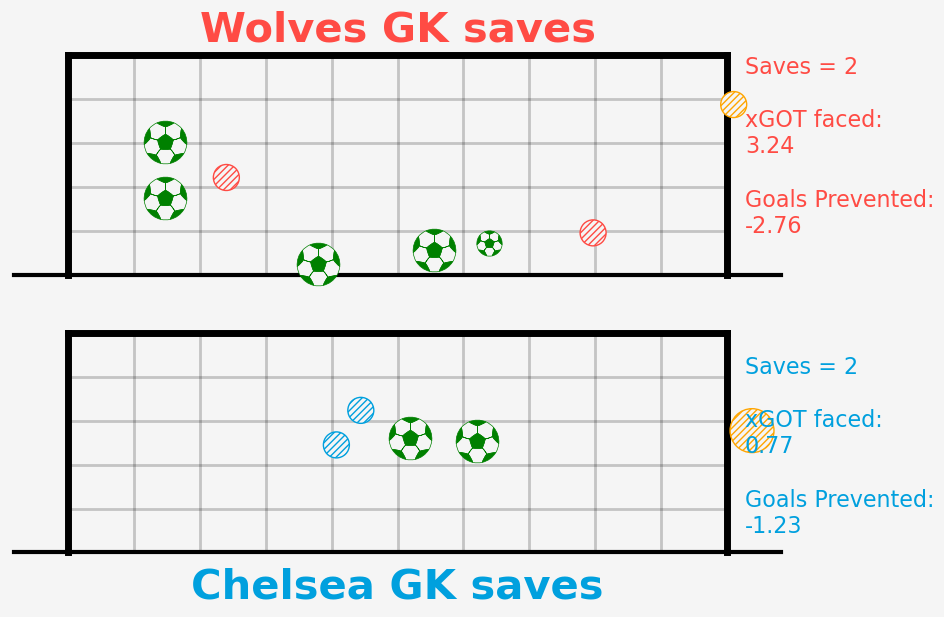

In [111]:
def plot_goalPost(ax):
    hShotsdf = Shotsdf[Shotsdf['teamName']==hteamName]
    aShotsdf = Shotsdf[Shotsdf['teamName']==ateamName]
    # converting the datapoints according to the pitch dimension, because the goalposts are being plotted inside the pitch using pitch's dimension
    hShotsdf['goalMouthZ'] = hShotsdf['goalMouthZ']*0.75
    aShotsdf['goalMouthZ'] = (aShotsdf['goalMouthZ']*0.75) + 38

    hShotsdf['goalMouthY'] = ((37.66 - hShotsdf['goalMouthY'])*12.295) + 7.5
    aShotsdf['goalMouthY'] = ((37.66 - aShotsdf['goalMouthY'])*12.295) + 7.5

    # plotting an invisible pitch using the pitch color and line color same color, because the goalposts are being plotted inside the pitch using pitch's dimension
    pitch = Pitch(pitch_type='uefa', corner_arcs=True, pitch_color=bg_color, line_color=bg_color, linewidth=2)
    pitch.draw(ax=ax)
    ax.set_ylim(-0.5,68.5)
    ax.set_xlim(-0.5,105.5)

    # away goalpost bars
    ax.plot([7.5, 7.5], [0, 30], color=line_color, linewidth=5)
    ax.plot([7.5, 97.5], [30, 30], color=line_color, linewidth=5)
    ax.plot([97.5, 97.5], [30, 0], color=line_color, linewidth=5)
    ax.plot([0, 105], [0, 0], color=line_color, linewidth=3)
    # plotting the away net
    y_values = np.arange(0, 6) * 6
    for y in y_values:
        ax.plot([7.5, 97.5], [y, y], color=line_color, linewidth=2, alpha=0.2)
    x_values = (np.arange(0, 11) * 9) + 7.5
    for x in x_values:
        ax.plot([x, x], [0, 30], color=line_color, linewidth=2, alpha=0.2)
    # home goalpost bars
    ax.plot([7.5, 7.5], [38, 68], color=line_color, linewidth=5)
    ax.plot([7.5, 97.5], [68, 68], color=line_color, linewidth=5)
    ax.plot([97.5, 97.5], [68, 38], color=line_color, linewidth=5)
    ax.plot([0, 105], [38, 38], color=line_color, linewidth=3)
    # plotting the home net
    y_values = (np.arange(0, 6) * 6) + 38
    for y in y_values:
        ax.plot([7.5, 97.5], [y, y], color=line_color, linewidth=2, alpha=0.2)
    x_values = (np.arange(0, 11) * 9) + 7.5
    for x in x_values:
        ax.plot([x, x], [38, 68], color=line_color, linewidth=2, alpha=0.2)

    # filtering different types of shots without BigChance
    hSavedf = hShotsdf[(hShotsdf['type']=='SavedShot') & (~hShotsdf['qualifiers'].str.contains(': 82,')) & (~hShotsdf['qualifiers'].str.contains('BigChance'))]
    hGoaldf = hShotsdf[(hShotsdf['type']=='Goal') & (~hShotsdf['qualifiers'].str.contains('OwnGoal')) & (~hShotsdf['qualifiers'].str.contains('BigChance'))]
    hPostdf = hShotsdf[(hShotsdf['type']=='ShotOnPost') & (~hShotsdf['qualifiers'].str.contains('BigChance'))]
    aSavedf = aShotsdf[(aShotsdf['type']=='SavedShot') & (~aShotsdf['qualifiers'].str.contains(': 82,')) & (~aShotsdf['qualifiers'].str.contains('BigChance'))]
    aGoaldf = aShotsdf[(aShotsdf['type']=='Goal') & (~aShotsdf['qualifiers'].str.contains('OwnGoal')) & (~aShotsdf['qualifiers'].str.contains('BigChance'))]
    aPostdf = aShotsdf[(aShotsdf['type']=='ShotOnPost') & (~aShotsdf['qualifiers'].str.contains('BigChance'))]
    # filtering different types of shots with BigChance
    hSavedf_bc = hShotsdf[(hShotsdf['type']=='SavedShot') & (~hShotsdf['qualifiers'].str.contains(': 82,')) & (hShotsdf['qualifiers'].str.contains('BigChance'))]
    hGoaldf_bc = hShotsdf[(hShotsdf['type']=='Goal') & (~hShotsdf['qualifiers'].str.contains('OwnGoal')) & (hShotsdf['qualifiers'].str.contains('BigChance'))]
    hPostdf_bc = hShotsdf[(hShotsdf['type']=='ShotOnPost') & (hShotsdf['qualifiers'].str.contains('BigChance'))]
    aSavedf_bc = aShotsdf[(aShotsdf['type']=='SavedShot') & (~aShotsdf['qualifiers'].str.contains(': 82,')) & (aShotsdf['qualifiers'].str.contains('BigChance'))]
    aGoaldf_bc = aShotsdf[(aShotsdf['type']=='Goal') & (~aShotsdf['qualifiers'].str.contains('OwnGoal')) & (aShotsdf['qualifiers'].str.contains('BigChance'))]
    aPostdf_bc = aShotsdf[(aShotsdf['type']=='ShotOnPost') & (aShotsdf['qualifiers'].str.contains('BigChance'))]

    # scattering those shots without BigChance
    sc1 = pitch.scatter(hSavedf.goalMouthY, hSavedf.goalMouthZ, marker='o', c=bg_color, zorder=3, edgecolor=acol, hatch='/////', s=350, ax=ax)
    sc2 = pitch.scatter(hGoaldf.goalMouthY, hGoaldf.goalMouthZ, marker='football', c=bg_color, zorder=3, edgecolors='green', s=350, ax=ax)
    sc3 = pitch.scatter(hPostdf.goalMouthY, hPostdf.goalMouthZ, marker='o', c=bg_color, zorder=3, edgecolors='orange', hatch='/////', s=350, ax=ax)
    sc4 = pitch.scatter(aSavedf.goalMouthY, aSavedf.goalMouthZ, marker='o', c=bg_color, zorder=3, edgecolor=hcol, hatch='/////', s=350, ax=ax)
    sc5 = pitch.scatter(aGoaldf.goalMouthY, aGoaldf.goalMouthZ, marker='football', c=bg_color, zorder=3, edgecolors='green', s=350, ax=ax)
    sc6 = pitch.scatter(aPostdf.goalMouthY, aPostdf.goalMouthZ, marker='o', c=bg_color, zorder=3, edgecolors='orange', hatch='/////', s=350, ax=ax)
    # scattering those shots with BigChance
    sc1_bc = pitch.scatter(hSavedf_bc.goalMouthY, hSavedf_bc.goalMouthZ, marker='o', c=bg_color, zorder=3, edgecolor=acol, hatch='/////', s=1000, ax=ax)
    sc2_bc = pitch.scatter(hGoaldf_bc.goalMouthY, hGoaldf_bc.goalMouthZ, marker='football', c=bg_color, zorder=3, edgecolors='green', s=1000, ax=ax)
    sc3_bc = pitch.scatter(hPostdf_bc.goalMouthY, hPostdf_bc.goalMouthZ, marker='o', c=bg_color, zorder=3, edgecolors='orange', hatch='/////', s=1000, ax=ax)
    sc4_bc = pitch.scatter(aSavedf_bc.goalMouthY, aSavedf_bc.goalMouthZ, marker='o', c=bg_color, zorder=3, edgecolor=hcol, hatch='/////', s=1000, ax=ax)
    sc5_bc = pitch.scatter(aGoaldf_bc.goalMouthY, aGoaldf_bc.goalMouthZ, marker='football', c=bg_color, zorder=3, edgecolors='green', s=1000, ax=ax)
    sc6_bc = pitch.scatter(aPostdf_bc.goalMouthY, aPostdf_bc.goalMouthZ, marker='o', c=bg_color, zorder=3, edgecolors='orange', hatch='/////', s=1000, ax=ax)

    # Headlines and other texts
    ax.text(52.5, 70, f"{hteamName} GK saves", color=hcol, fontsize=30, ha='center', fontweight='bold')
    ax.text(52.5, -2, f"{ateamName} GK saves", color=acol, fontsize=30, ha='center', va='top', fontweight='bold')

    ax.text(100, 68, f"Saves = {len(aSavedf)+len(aSavedf_bc)}\n\nxGOT faced:\n{axgot}\n\nGoals Prevented:\n{round(axgot - len(aGoaldf) - len(aGoaldf_bc),2)}",
                    color=hcol, fontsize=16, va='top', ha='left')
    ax.text(100, 2, f"Saves = {len(hSavedf)+len(hSavedf_bc)}\n\nxGOT faced:\n{hxgot}\n\nGoals Prevented:\n{round(hxgot - len(hGoaldf) - len(hGoaldf_bc),2)}",
                    color=acol, fontsize=16, va='bottom', ha='left')

    home_data = {
        'Team_Name': hteamName,
        'Shots_Saved': len(hSavedf)+len(hSavedf_bc),
        'Big_Chance_Saved': len(hSavedf_bc),
        'Goals_Prevented': round(hxgot - len(hGoaldf) - len(hGoaldf_bc),2)
    }
    
    away_data = {
        'Team_Name': ateamName,
        'Shots_Saved': len(aSavedf)+len(aSavedf_bc),
        'Big_Chance_Saved': len(aSavedf_bc),
        'Goals_Prevented': round(axgot - len(aGoaldf) - len(aGoaldf_bc),2)
    }
    
    return [home_data, away_data]

fig,ax=plt.subplots(figsize=(10,10), facecolor=bg_color)
goalkeeping_stats = plot_goalPost(ax)
goalkeeping_stats_df = pd.DataFrame(goalkeeping_stats)

C:\Users\kevin\AppData\Local\Temp\ipykernel_12360\1726592553.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  Momentumdf['average_xT'].fillna(0, inplace=True)


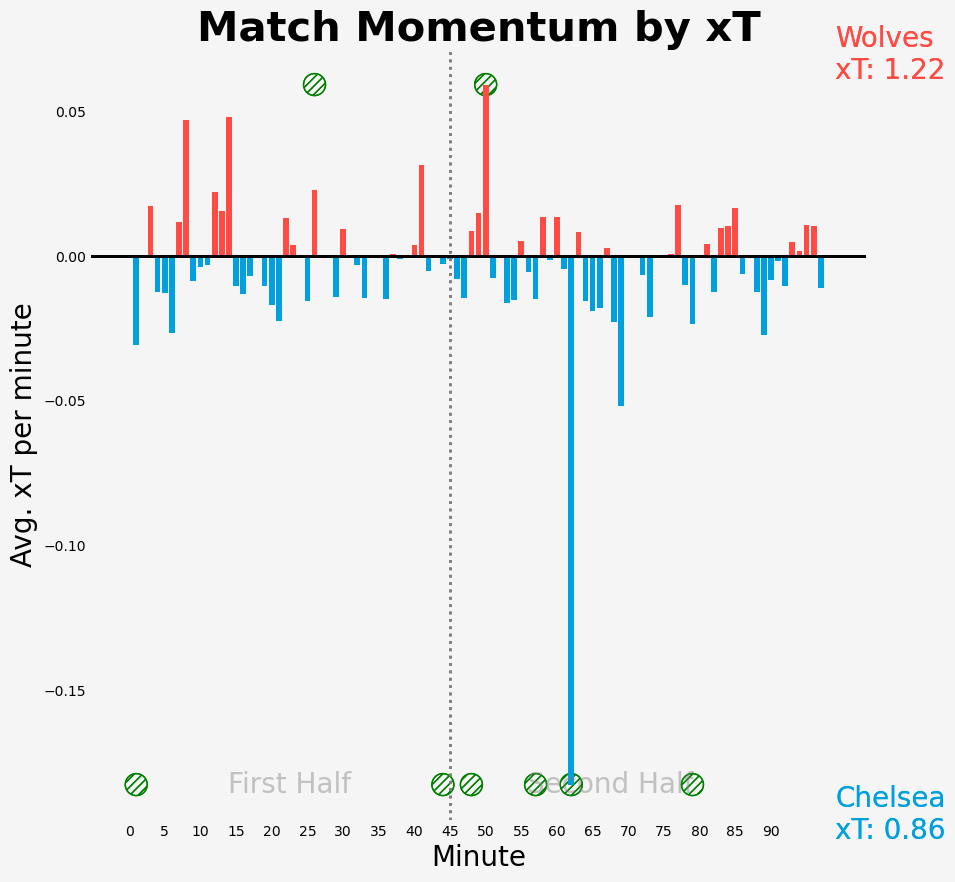

In [113]:
Momentumdf = df.copy()
# multiplying the away teams xT values with -1 so that I can plot them in the opposite of home teams
Momentumdf.loc[Momentumdf['teamName'] == ateamName, 'end_zone_value_xT'] *= -1
# taking average xT per minute
Momentumdf = Momentumdf.groupby('minute')['end_zone_value_xT'].mean()
Momentumdf = Momentumdf.reset_index()
Momentumdf.columns = ['minute', 'average_xT']
Momentumdf['average_xT'].fillna(0, inplace=True)
# Momentumdf['average_xT'] = Momentumdf['average_xT'].rolling(window=2, min_periods=1).median()

def plot_Momentum(ax):
    # Set colors based on positive or negative values
    colors = [hcol if x > 0 else acol for x in Momentumdf['average_xT']]

    # making a list of munutes when goals are scored
    hgoal_list = homedf[(homedf['type'] == 'Goal') & (~homedf['qualifiers'].str.contains('OwnGoal'))]['minute'].tolist()
    agoal_list = awaydf[(awaydf['type'] == 'Goal') & (~awaydf['qualifiers'].str.contains('OwnGoal'))]['minute'].tolist()
    hog_list = homedf[(homedf['type'] == 'Goal') & (homedf['qualifiers'].str.contains('OwnGoal'))]['minute'].tolist()
    aog_list = awaydf[(awaydf['type'] == 'Goal') & (awaydf['qualifiers'].str.contains('OwnGoal'))]['minute'].tolist()
    hred_list = homedf[homedf['qualifiers'].str.contains('Red|SecondYellow')]['minute'].tolist()
    ared_list = awaydf[awaydf['qualifiers'].str.contains('Red|SecondYellow')]['minute'].tolist()

    # plotting scatters when goals are scored
    highest_xT = Momentumdf['average_xT'].max()
    lowest_xT = Momentumdf['average_xT'].min()
    highest_minute = Momentumdf['minute'].max()
    hscatter_y = [highest_xT]*len(hgoal_list)
    ascatter_y = [lowest_xT]*len(agoal_list)
    hogscatter_y = [highest_xT]*len(aog_list)
    aogscatter_y = [lowest_xT]*len(hog_list)
    hred_y = [highest_xT]*len(hred_list)
    ared_y = [lowest_xT]*len(ared_list)

    ax.text((45/2), lowest_xT, 'First Half', color='gray', fontsize=20, alpha=0.25, va='center', ha='center')
    ax.text((45+(45/2)), lowest_xT, 'Second Half', color='gray', fontsize=20, alpha=0.25, va='center', ha='center')

    ax.scatter(hgoal_list, hscatter_y, s=250, c='None', edgecolor='green', hatch='////', marker='o')
    ax.scatter(agoal_list, ascatter_y, s=250, c='None', edgecolor='green', hatch='////', marker='o')
    ax.scatter(hog_list, aogscatter_y, s=250, c='None', edgecolor='orange', hatch='////', marker='o')
    ax.scatter(aog_list, hogscatter_y, s=250, c='None', edgecolor='orange', hatch='////', marker='o')
    ax.scatter(hred_list, hred_y, s=250, c='None', edgecolor='red', hatch='////', marker='s')
    ax.scatter(ared_list, ared_y, s=250, c='None', edgecolor='red', hatch='////', marker='s')

    # Creating the bar plot
    ax.bar(Momentumdf['minute'], Momentumdf['average_xT'], color=colors)
    ax.set_xticks(range(0, len(Momentumdf['minute']), 5))
    ax.axvline(45, color='gray', linewidth=2, linestyle='dotted')
    # ax.axvline(90, color='gray', linewidth=2, linestyle='dotted')
    ax.set_facecolor(bg_color)
    # Hide spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    # # Hide ticks
    ax.tick_params(axis='both', which='both', length=0)
    ax.tick_params(axis='x', colors=line_color)
    ax.tick_params(axis='y', colors=line_color)
    # Add labels and title
    ax.set_xlabel('Minute', color=line_color, fontsize=20)
    ax.set_ylabel('Avg. xT per minute', color=line_color, fontsize=20)
    ax.axhline(y=0, color=line_color, alpha=1, linewidth=2)

    ax.text(highest_minute+1,highest_xT, f"{hteamName}\nxT: {hxT}", color=hcol, fontsize=20, va='bottom', ha='left')
    ax.text(highest_minute+1,lowest_xT,  f"{ateamName}\nxT: {axT}", color=acol, fontsize=20, va='top', ha='left')

    ax.set_title('Match Momentum by xT', color=line_color, fontsize=30, fontweight='bold')

    home_data = {
        'Team_Name': hteamName,
        'xT': hxT
    }
    
    away_data = {
        'Team_Name': ateamName,
        'xT': axT
    }
    
    return [home_data, away_data]

fig,ax=plt.subplots(figsize=(10,10), facecolor=bg_color)
plot_Momentum(ax)
xT_stats = plot_Momentum(ax)
xT_stats_df = pd.DataFrame(xT_stats)

C:\Users\kevin\AppData\Local\Temp\ipykernel_12360\3786013037.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  home_goalkick['qualifiers'] = home_goalkick['qualifiers'].apply(ast.literal_eval)
C:\Users\kevin\AppData\Local\Temp\ipykernel_12360\3786013037.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  away_goalkick['qualifiers'] = away_goalkick['qualifiers'].apply(ast.literal_eval)
C:\Users\kevin\AppData\Local\Temp\ipykernel_12360\3786013037.py:68: SettingWithCopyWarning: 
A value is trying to be set

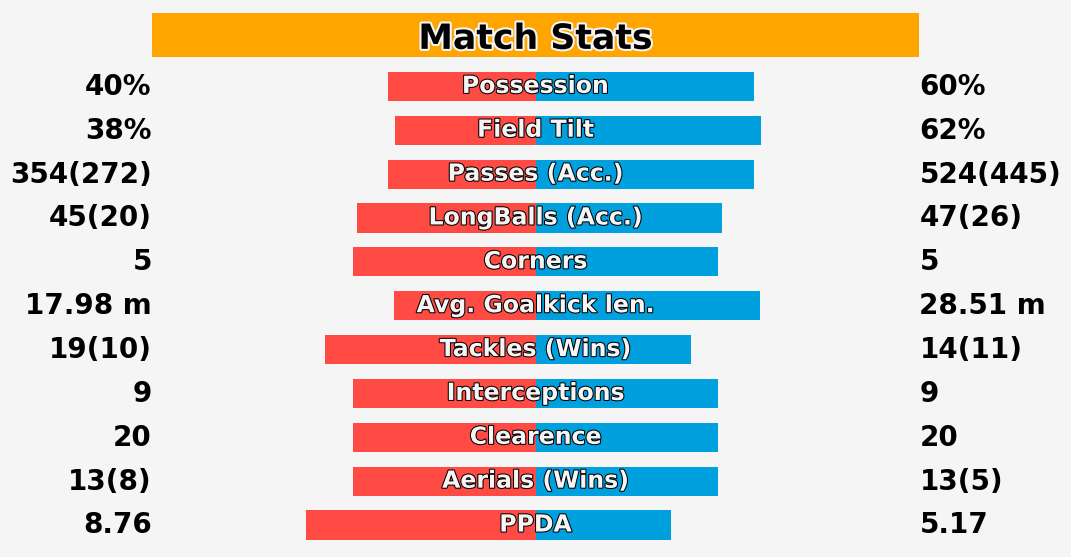

In [115]:
# Here I have calculated a lot of stats, all of them I couldn't show in the viz because of lack of spaces, but I kept those in the code

# Passing Stats

#Possession%
hpossdf = df[(df['teamName']==hteamName) & (df['type']=='Pass')]
apossdf = df[(df['teamName']==ateamName) & (df['type']=='Pass')]
hposs = round((len(hpossdf)/(len(hpossdf)+len(apossdf)))*100,2)
aposs = round((len(apossdf)/(len(hpossdf)+len(apossdf)))*100,2)
#Field Tilt%
hftdf = df[(df['teamName']==hteamName) & (df['isTouch']==1) & (df['x']>=70)]
aftdf = df[(df['teamName']==ateamName) & (df['isTouch']==1) & (df['x']>=70)]
hft = round((len(hftdf)/(len(hftdf)+len(aftdf)))*100,2)
aft = round((len(aftdf)/(len(hftdf)+len(aftdf)))*100,2)
#Total Passes
htotalPass = len(df[(df['teamName']==hteamName) & (df['type']=='Pass')])
atotalPass = len(df[(df['teamName']==ateamName) & (df['type']=='Pass')])
#Accurate Pass
hAccPass = len(df[(df['teamName']==hteamName) & (df['type']=='Pass') & (df['outcomeType']=='Successful')])
aAccPass = len(df[(df['teamName']==ateamName) & (df['type']=='Pass') & (df['outcomeType']=='Successful')])
#Accurate Pass (without defensive third)
hAccPasswdt = len(df[(df['teamName']==hteamName) & (df['type']=='Pass') & (df['outcomeType']=='Successful') & (df['endX']>35)])
aAccPasswdt = len(df[(df['teamName']==ateamName) & (df['type']=='Pass') & (df['outcomeType']=='Successful') & (df['endX']>35)])
#LongBall
hLongB = len(df[(df['teamName']==hteamName) & (df['type']=='Pass') & (df['qualifiers'].str.contains('Longball')) & (~df['qualifiers'].str.contains('Corner')) & (~df['qualifiers'].str.contains('Cross'))])
aLongB = len(df[(df['teamName']==ateamName) & (df['type']=='Pass') & (df['qualifiers'].str.contains('Longball')) & (~df['qualifiers'].str.contains('Corner')) & (~df['qualifiers'].str.contains('Cross'))])
#Accurate LongBall
hAccLongB = len(df[(df['teamName']==hteamName) & (df['type']=='Pass') & (df['qualifiers'].str.contains('Longball')) & (df['outcomeType']=='Successful') & (~df['qualifiers'].str.contains('Corner')) & (~df['qualifiers'].str.contains('Cross'))])
aAccLongB = len(df[(df['teamName']==ateamName) & (df['type']=='Pass') & (df['qualifiers'].str.contains('Longball')) & (df['outcomeType']=='Successful') & (~df['qualifiers'].str.contains('Corner')) & (~df['qualifiers'].str.contains('Cross'))])
#Crosses
hCrss= len(df[(df['teamName']==hteamName) & (df['type']=='Pass') & (df['qualifiers'].str.contains('Cross'))])
aCrss= len(df[(df['teamName']==ateamName) & (df['type']=='Pass') & (df['qualifiers'].str.contains('Cross'))])
#Accurate Crosses
hAccCrss= len(df[(df['teamName']==hteamName) & (df['type']=='Pass') & (df['qualifiers'].str.contains('Cross')) & (df['outcomeType']=='Successful')])
aAccCrss= len(df[(df['teamName']==ateamName) & (df['type']=='Pass') & (df['qualifiers'].str.contains('Cross')) & (df['outcomeType']=='Successful')])
#Freekick
hfk= len(df[(df['teamName']==hteamName) & (df['type']=='Pass') & (df['qualifiers'].str.contains('Freekick'))])
afk= len(df[(df['teamName']==ateamName) & (df['type']=='Pass') & (df['qualifiers'].str.contains('Freekick'))])
#Corner
hCor= len(df[(df['teamName']==hteamName) & (df['type']=='Pass') & (df['qualifiers'].str.contains('Corner'))])
aCor= len(df[(df['teamName']==ateamName) & (df['type']=='Pass') & (df['qualifiers'].str.contains('Corner'))])
#ThrowIn
htins= len(df[(df['teamName']==hteamName) & (df['type']=='Pass') & (df['qualifiers'].str.contains('ThrowIn'))])
atins= len(df[(df['teamName']==ateamName) & (df['type']=='Pass') & (df['qualifiers'].str.contains('ThrowIn'))])
#GoalKicks
hglkk= len(df[(df['teamName']==hteamName) & (df['type']=='Pass') & (df['qualifiers'].str.contains('GoalKick'))])
aglkk= len(df[(df['teamName']==ateamName) & (df['type']=='Pass') & (df['qualifiers'].str.contains('GoalKick'))])
#Dribbling
htotalDrb = len(df[(df['teamName']==hteamName) & (df['type']=='TakeOn') & (df['qualifiers'].str.contains('Offensive'))])
atotalDrb = len(df[(df['teamName']==ateamName) & (df['type']=='TakeOn') & (df['qualifiers'].str.contains('Offensive'))])
#Accurate TakeOn
hAccDrb = len(df[(df['teamName']==hteamName) & (df['type']=='TakeOn') & (df['qualifiers'].str.contains('Offensive')) & (df['outcomeType']=='Successful')])
aAccDrb = len(df[(df['teamName']==ateamName) & (df['type']=='TakeOn') & (df['qualifiers'].str.contains('Offensive')) & (df['outcomeType']=='Successful')])
#GoalKick Length
home_goalkick = df[(df['teamName']==hteamName) & (df['type']=='Pass') & (df['qualifiers'].str.contains('GoalKick'))]
away_goalkick = df[(df['teamName']==ateamName) & (df['type']=='Pass') & (df['qualifiers'].str.contains('GoalKick'))]
import ast
# Convert 'qualifiers' column from string to list of dictionaries
home_goalkick['qualifiers'] = home_goalkick['qualifiers'].apply(ast.literal_eval)
away_goalkick['qualifiers'] = away_goalkick['qualifiers'].apply(ast.literal_eval)
# Function to extract value of 'Length'
def extract_length(qualifiers):
    for item in qualifiers:
        if 'displayName' in item['type'] and item['type']['displayName'] == 'Length':
            return float(item['value'])
    return None
# Apply the function to the 'qualifiers' column
home_goalkick['length'] = home_goalkick['qualifiers'].apply(extract_length).astype(float)
away_goalkick['length'] = away_goalkick['qualifiers'].apply(extract_length).astype(float)
hglkl = round(home_goalkick['length'].mean(),2)
aglkl = round(away_goalkick['length'].mean(),2)


# Defensive Stats

#Tackles
htkl = len(df[(df['teamName']==hteamName) & (df['type']=='Tackle')])
atkl = len(df[(df['teamName']==ateamName) & (df['type']=='Tackle')])
#Tackles Won
htklw = len(df[(df['teamName']==hteamName) & (df['type']=='Tackle') & (df['outcomeType']=='Successful')])
atklw = len(df[(df['teamName']==ateamName) & (df['type']=='Tackle') & (df['outcomeType']=='Successful')])
#Interceptions
hintc= len(df[(df['teamName']==hteamName) & (df['type']=='Interception')])
aintc= len(df[(df['teamName']==ateamName) & (df['type']=='Interception')])
#Clearances
hclr= len(df[(df['teamName']==hteamName) & (df['type']=='Clearance')])
aclr= len(df[(df['teamName']==ateamName) & (df['type']=='Clearance')])
#Aerials
harl= len(df[(df['teamName']==hteamName) & (df['type']=='Aerial')])
aarl= len(df[(df['teamName']==ateamName) & (df['type']=='Aerial')])
#Aerials Wins
harlw= len(df[(df['teamName']==hteamName) & (df['type']=='Aerial') & (df['outcomeType']=='Successful')])
aarlw= len(df[(df['teamName']==ateamName) & (df['type']=='Aerial') & (df['outcomeType']=='Successful')])
#BallRecovery
hblrc= len(df[(df['teamName']==hteamName) & (df['type']=='BallRecovery')])
ablrc= len(df[(df['teamName']==ateamName) & (df['type']=='BallRecovery')])
#BlockedPass
hblkp= len(df[(df['teamName']==hteamName) & (df['type']=='BlockedPass')])
ablkp= len(df[(df['teamName']==ateamName) & (df['type']=='BlockedPass')])
#OffsideGiven
hofs= len(df[(df['teamName']==hteamName) & (df['type']=='OffsideGiven')])
aofs= len(df[(df['teamName']==ateamName) & (df['type']=='OffsideGiven')])
#Fouls
hfoul= len(df[(df['teamName']==hteamName) & (df['type']=='Foul')])
afoul= len(df[(df['teamName']==ateamName) & (df['type']=='Foul')])

# PPDA
home_def_acts = df[(df['teamName']==hteamName) & (df['type'].str.contains('Interception|Foul|Challenge|BlockedPass|Tackle')) & (df['x']>35)]
away_def_acts = df[(df['teamName']==ateamName) & (df['type'].str.contains('Interception|Foul|Challenge|BlockedPass|Tackle')) & (df['x']>35)]
home_pass = df[(df['teamName']==hteamName) & (df['type']=='Pass') & (df['outcomeType']=='Successful') & (df['x']<70)]
away_pass = df[(df['teamName']==ateamName) & (df['type']=='Pass') & (df['outcomeType']=='Successful') & (df['x']<70)]
home_ppda = round((len(away_pass)/len(home_def_acts)), 2)
away_ppda = round((len(home_pass)/len(away_def_acts)), 2)

# Average Passes per Sequence
pass_df_home = df[(df['type'] == 'Pass') & (df['teamName']==hteamName)]
pass_counts_home = pass_df_home.groupby('possession_id').size()
PPS_home = pass_counts_home.mean().round()
pass_df_away = df[(df['type'] == 'Pass') & (df['teamName']==ateamName)]
pass_counts_away = pass_df_away.groupby('possession_id').size()
PPS_away = pass_counts_away.mean().round()

# Number of Sequence with 10+ Passes
possessions_with_10_or_more_passes = pass_counts_home[pass_counts_home >= 10]
pass_seq_10_more_home = possessions_with_10_or_more_passes.count()
possessions_with_10_or_more_passes = pass_counts_away[pass_counts_away >= 10]
pass_seq_10_more_away = possessions_with_10_or_more_passes.count()

path_eff1 = [path_effects.Stroke(linewidth=1.5, foreground=line_color), path_effects.Normal()]

def plotting_match_stats(ax):
    pitch = Pitch(pitch_type='uefa', corner_arcs=True, pitch_color=bg_color, line_color=bg_color, linewidth=2)
    pitch.draw(ax=ax)
    ax.set_xlim(-0.5, 105.5)
    ax.set_ylim(-5, 68.5)

    # plotting the headline box
    head_y = [62,68,68,62]
    head_x = [0,0,105,105]
    ax.fill(head_x, head_y, 'orange')
    ax.text(52.5,64.5, "Match Stats", ha='center', va='center', color=line_color, fontsize=25, fontweight='bold', path_effects=path_eff)

    # Stats bar diagram
    stats_title = [58, 58-(1*6), 58-(2*6), 58-(3*6), 58-(4*6), 58-(5*6), 58-(6*6), 58-(7*6), 58-(8*6), 58-(9*6), 58-(10*6)] # y co-ordinate values of the bars
    stats_home = [hposs, hft, htotalPass, hLongB, hCor, hglkl, htkl, hintc, hclr, harl, home_ppda]
    stats_away = [aposs, aft, atotalPass, aLongB, aCor, aglkl, atkl, aintc, aclr, aarl, away_ppda]

    stats_normalized_home = [-(hposs/(hposs+aposs))*50, -(hft/(hft+aft))*50, -(htotalPass/(htotalPass+atotalPass))*50,
                                        -(hLongB/(hLongB+aLongB))*50, -(hCor/(hCor+aCor))*50, -(hglkl/(hglkl+aglkl))*50, -(htkl/(htkl+atkl))*50,       # put a (-) sign before each value so that the
                                        -(hintc/(hintc+aintc))*50, -(hclr/(hclr+aclr))*50, -(harl/(harl+aarl))*50, -(home_ppda/(home_ppda+away_ppda))*50]          # home stats bar shows in the opposite of away
    stats_normalized_away = [(aposs/(hposs+aposs))*50, (aft/(hft+aft))*50, (atotalPass/(htotalPass+atotalPass))*50,
                                        (aLongB/(hLongB+aLongB))*50, (aCor/(hCor+aCor))*50, (aglkl/(hglkl+aglkl))*50, (atkl/(htkl+atkl))*50,
                                        (aintc/(hintc+aintc))*50, (aclr/(hclr+aclr))*50, (aarl/(harl+aarl))*50, (away_ppda/(home_ppda+away_ppda))*50]

    start_x = 52.5
    ax.barh(stats_title, stats_normalized_home, height=4, color=hcol, left=start_x)
    ax.barh(stats_title, stats_normalized_away, height=4, left=start_x, color=acol)
    # Turn off axis-related elements
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False)
    ax.set_xticks([])
    ax.set_yticks([])

    # Plotting the texts
    ax.text(52.5, 58, "Possession", color=bg_color, fontsize=17, ha='center', va='center', fontweight='bold', path_effects=path_eff1)
    ax.text(52.5, 58-(1*6), "Field Tilt", color=bg_color, fontsize=17, ha='center', va='center', fontweight='bold', path_effects=path_eff1)
    ax.text(52.5, 58-(2*6), "Passes (Acc.)", color=bg_color, fontsize=17, ha='center', va='center', fontweight='bold', path_effects=path_eff1)
    ax.text(52.5, 58-(3*6), "LongBalls (Acc.)", color=bg_color, fontsize=17, ha='center', va='center', fontweight='bold', path_effects=path_eff1)
    ax.text(52.5, 58-(4*6), "Corners", color=bg_color, fontsize=17, ha='center', va='center', fontweight='bold', path_effects=path_eff1)
    ax.text(52.5, 58-(5*6), "Avg. Goalkick len.", color=bg_color, fontsize=17, ha='center', va='center', fontweight='bold', path_effects=path_eff1)
    ax.text(52.5, 58-(6*6), "Tackles (Wins)", color=bg_color, fontsize=17, ha='center', va='center', fontweight='bold', path_effects=path_eff1)
    ax.text(52.5, 58-(7*6), "Interceptions", color=bg_color, fontsize=17, ha='center', va='center', fontweight='bold', path_effects=path_eff1)
    ax.text(52.5, 58-(8*6), "Clearence", color=bg_color, fontsize=17, ha='center', va='center', fontweight='bold', path_effects=path_eff1)
    ax.text(52.5, 58-(9*6), "Aerials (Wins)", color=bg_color, fontsize=17, ha='center', va='center', fontweight='bold', path_effects=path_eff1)
    ax.text(52.5, 58-(10*6), "PPDA", color=bg_color, fontsize=17, ha='center', va='center', fontweight='bold', path_effects=path_eff1)

    ax.text(0, 58, f"{round(hposs)}%", color=line_color, fontsize=20, ha='right', va='center', fontweight='bold')
    ax.text(0, 58-(1*6), f"{round(hft)}%", color=line_color, fontsize=20, ha='right', va='center', fontweight='bold')
    ax.text(0, 58-(2*6), f"{htotalPass}({hAccPass})", color=line_color, fontsize=20, ha='right', va='center', fontweight='bold')
    ax.text(0, 58-(3*6), f"{hLongB}({hAccLongB})", color=line_color, fontsize=20, ha='right', va='center', fontweight='bold')
    ax.text(0, 58-(4*6), f"{hCor}", color=line_color, fontsize=20, ha='right', va='center', fontweight='bold')
    ax.text(0, 58-(5*6), f"{hglkl} m", color=line_color, fontsize=20, ha='right', va='center', fontweight='bold')
    ax.text(0, 58-(6*6), f"{htkl}({htklw})", color=line_color, fontsize=20, ha='right', va='center', fontweight='bold')
    ax.text(0, 58-(7*6), f"{hintc}", color=line_color, fontsize=20, ha='right', va='center', fontweight='bold')
    ax.text(0, 58-(8*6), f"{hclr}", color=line_color, fontsize=20, ha='right', va='center', fontweight='bold')
    ax.text(0, 58-(9*6), f"{harl}({harlw})", color=line_color, fontsize=20, ha='right', va='center', fontweight='bold')
    ax.text(0, 58-(10*6), f"{home_ppda}", color=line_color, fontsize=20, ha='right', va='center', fontweight='bold')

    ax.text(105, 58, f"{round(aposs)}%", color=line_color, fontsize=20, ha='left', va='center', fontweight='bold')
    ax.text(105, 58-(1*6), f"{round(aft)}%", color=line_color, fontsize=20, ha='left', va='center', fontweight='bold')
    ax.text(105, 58-(2*6), f"{atotalPass}({aAccPass})", color=line_color, fontsize=20, ha='left', va='center', fontweight='bold')
    ax.text(105, 58-(3*6), f"{aLongB}({aAccLongB})", color=line_color, fontsize=20, ha='left', va='center', fontweight='bold')
    ax.text(105, 58-(4*6), f"{aCor}", color=line_color, fontsize=20, ha='left', va='center', fontweight='bold')
    ax.text(105, 58-(5*6), f"{aglkl} m", color=line_color, fontsize=20, ha='left', va='center', fontweight='bold')
    ax.text(105, 58-(6*6), f"{atkl}({atklw})", color=line_color, fontsize=20, ha='left', va='center', fontweight='bold')
    ax.text(105, 58-(7*6), f"{aintc}", color=line_color, fontsize=20, ha='left', va='center', fontweight='bold')
    ax.text(105, 58-(8*6), f"{aclr}", color=line_color, fontsize=20, ha='left', va='center', fontweight='bold')
    ax.text(105, 58-(9*6), f"{aarl}({aarlw})", color=line_color, fontsize=20, ha='left', va='center', fontweight='bold')
    ax.text(105, 58-(10*6), f"{away_ppda}", color=line_color, fontsize=20, ha='left', va='center', fontweight='bold')

    home_data = {
        'Team_Name': hteamName,
        'Possession_%': hposs,
        'Field_Tilt_%': hft,
        'Total_Passes': htotalPass,
        'Accurate_Passes': hAccPass,
        'Longballs': hLongB,
        'Accurate_Longballs': hAccLongB,
        'Corners': hCor,
        'Avg.GoalKick_Length': hglkl,
        'Tackles': htkl,
        'Tackles_Won': htklw,
        'Interceptions': hintc,
        'Clearances': hclr,
        'Aerial_Duels': harl,
        'Aerial_Duels_Won': harlw,
        'Passes_Per_Defensive_Actions(PPDA)': home_ppda,
        'Average_Passes_Per_Sequences': PPS_home,
        '10+_Passing_Sequences': pass_seq_10_more_home
    }
    
    away_data = {
        'Team_Name': ateamName,
        'Possession_%': aposs,
        'Field_Tilt_%': aft,
        'Total_Passes': atotalPass,
        'Accurate_Passes': aAccPass,
        'Longballs': aLongB,
        'Accurate_Longballs': aAccLongB,
        'Corners': aCor,
        'Avg.GoalKick_Length': aglkl,
        'Tackles': atkl,
        'Tackles_Won': atklw,
        'Interceptions': aintc,
        'Clearances': aclr,
        'Aerial_Duels': aarl,
        'Aerial_Duels_Won': aarlw,
        'Passes_Per_Defensive_Actions(PPDA)': away_ppda,
        'Average_Passes_Per_Sequences': PPS_away,
        '10+_Passing_Sequences': pass_seq_10_more_away
    }
    
    return [home_data, away_data]

fig,ax=plt.subplots(figsize=(10,10), facecolor=bg_color)
general_match_stats = plotting_match_stats(ax)
general_match_stats_df = pd.DataFrame(general_match_stats)

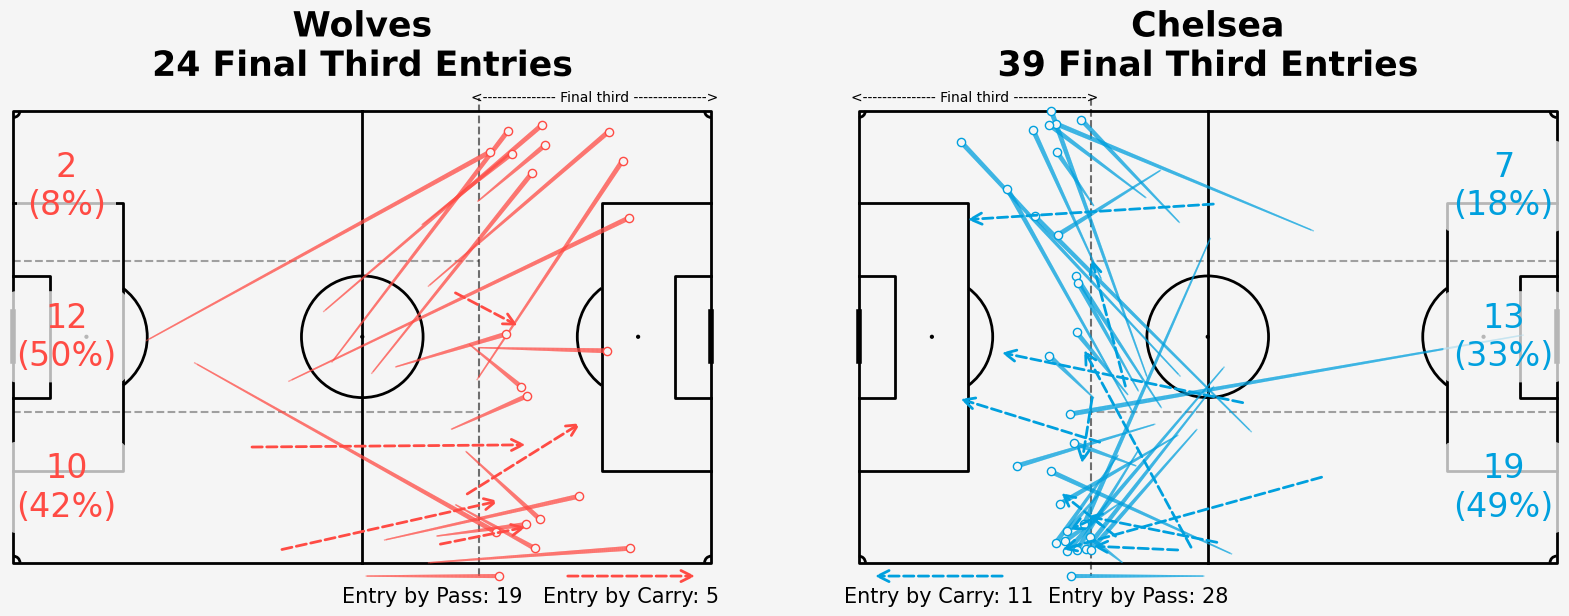

In [117]:
def Final_third_entry(ax, team_name, col):
    # Final third Entry means passes or carries which has started outside the Final third and ended inside the final third
    dfpass = df[(df['teamName']==team_name) & (df['type']=='Pass') & (df['x']<70) & (df['endX']>=70) & (df['outcomeType']=='Successful') &
                (~df['qualifiers'].str.contains('Freekick'))]
    dfcarry = df[(df['teamName']==team_name) & (df['type']=='Carry') & (df['x']<70) & (df['endX']>=70)]
    pitch = Pitch(pitch_type='uefa', pitch_color=bg_color, line_color=line_color, linewidth=2,
                          corner_arcs=True)
    pitch.draw(ax=ax)
    ax.set_xlim(-0.5, 105.5)
    # ax.set_ylim(-0.5, 68.5)

    if team_name == ateamName:
        ax.invert_xaxis()
        ax.invert_yaxis()

    pass_count = len(dfpass) + len(dfcarry)

    # calculating the counts
    left_entry = len(dfpass[dfpass['y']>=45.33]) + len(dfcarry[dfcarry['y']>=45.33])
    mid_entry = len(dfpass[(dfpass['y']>=22.67) & (dfpass['y']<45.33)]) + len(dfcarry[(dfcarry['y']>=22.67) & (dfcarry['y']<45.33)])
    right_entry = len(dfpass[(dfpass['y']>=0) & (dfpass['y']<22.67)]) + len(dfcarry[(dfcarry['y']>=0) & (dfcarry['y']<22.67)])
    left_percentage = round((left_entry/pass_count)*100)
    mid_percentage = round((mid_entry/pass_count)*100)
    right_percentage = round((right_entry/pass_count)*100)

    ax.hlines(22.67, xmin=0, xmax=70, colors=line_color, linestyle='dashed', alpha=0.35)
    ax.hlines(45.33, xmin=0, xmax=70, colors=line_color, linestyle='dashed', alpha=0.35)
    ax.vlines(70, ymin=-2, ymax=70, colors=line_color, linestyle='dashed', alpha=0.55)

    # showing the texts in the pitch
    bbox_props = dict(boxstyle="round,pad=0.3", edgecolor="None", facecolor=bg_color, alpha=0.75)
    if col == hcol:
        ax.text(8, 11.335, f'{right_entry}\n({right_percentage}%)', color=hcol, fontsize=24, va='center', ha='center', bbox=bbox_props)
        ax.text(8, 34, f'{mid_entry}\n({mid_percentage}%)', color=hcol, fontsize=24, va='center', ha='center', bbox=bbox_props)
        ax.text(8, 56.675, f'{left_entry}\n({left_percentage}%)', color=hcol, fontsize=24, va='center', ha='center', bbox=bbox_props)
    else:
        ax.text(8, 11.335, f'{right_entry}\n({right_percentage}%)', color=acol, fontsize=24, va='center', ha='center', bbox=bbox_props)
        ax.text(8, 34, f'{mid_entry}\n({mid_percentage}%)', color=acol, fontsize=24, va='center', ha='center', bbox=bbox_props)
        ax.text(8, 56.675, f'{left_entry}\n({left_percentage}%)', color=acol, fontsize=24, va='center', ha='center', bbox=bbox_props)

    # plotting the passes
    pro_pass = pitch.lines(dfpass.x, dfpass.y, dfpass.endX, dfpass.endY, lw=3.5, comet=True, color=col, ax=ax, alpha=0.5)
    # plotting some scatters at the end of each pass
    pro_pass_end = pitch.scatter(dfpass.endX, dfpass.endY, s=35, edgecolor=col, linewidth=1, color=bg_color, zorder=2, ax=ax)
    # plotting carries
    for index, row in dfcarry.iterrows():
        arrow = patches.FancyArrowPatch((row['x'], row['y']), (row['endX'], row['endY']), arrowstyle='->', color=col, zorder=4, mutation_scale=20, 
                                        alpha=1, linewidth=2, linestyle='--')
        ax.add_patch(arrow)

    counttext = f"{pass_count} Final Third Entries"

    # Heading and other texts
    if col == hcol:
        ax.set_title(f"{hteamName}\n{counttext}", color=line_color, fontsize=25, fontweight='bold', path_effects=path_eff)
        ax.text(87.5, 70, '<--------------- Final third --------------->', color=line_color, ha='center', va='center')
        pitch.lines(53, -2, 73, -2, lw=3, transparent=True, comet=True, color=col, ax=ax, alpha=0.5)
        ax.scatter(73,-2, s=35, edgecolor=col, linewidth=1, color=bg_color, zorder=2)
        arrow = patches.FancyArrowPatch((83, -2), (103, -2), arrowstyle='->', color=col, zorder=4, mutation_scale=20, 
                                        alpha=1, linewidth=2, linestyle='--')
        ax.add_patch(arrow)
        ax.text(63, -5, f'Entry by Pass: {len(dfpass)}', fontsize=15, color=line_color, ha='center', va='center')
        ax.text(93, -5, f'Entry by Carry: {len(dfcarry)}', fontsize=15, color=line_color, ha='center', va='center')
        
    else:
        ax.set_title(f"{ateamName}\n{counttext}", color=line_color, fontsize=25, fontweight='bold', path_effects=path_eff)
        ax.text(87.5, -2, '<--------------- Final third --------------->', color=line_color, ha='center', va='center')
        pitch.lines(53, 70, 73, 70, lw=3, transparent=True, comet=True, color=col, ax=ax, alpha=0.5)
        ax.scatter(73,70, s=35, edgecolor=col, linewidth=1, color=bg_color, zorder=2)
        arrow = patches.FancyArrowPatch((83, 70), (103, 70), arrowstyle='->', color=col, zorder=4, mutation_scale=20, 
                                        alpha=1, linewidth=2, linestyle='--')
        ax.add_patch(arrow)
        ax.text(63, 73, f'Entry by Pass: {len(dfpass)}', fontsize=15, color=line_color, ha='center', va='center')
        ax.text(93, 73, f'Entry by Carry: {len(dfcarry)}', fontsize=15, color=line_color, ha='center', va='center')

    return {
        'Team_Name': team_name,
        'Total_Final_Third_Entries': pass_count,
        'Final_Third_Entries_From_Left': left_entry,
        'Final_Third_Entries_From_Center': mid_entry,
        'Final_Third_Entries_From_Right': right_entry,
        'Entry_By_Pass': len(dfpass),
        'Entry_By_Carry': len(dfcarry)
    }

fig,axs=plt.subplots(1,2, figsize=(20,10), facecolor=bg_color)
final_third_entry_stats_home = Final_third_entry(axs[0], hteamName, hcol)
final_third_entry_stats_away = Final_third_entry(axs[1], ateamName, acol)
final_third_entry_stats_list = []
final_third_entry_stats_list.append(final_third_entry_stats_home)
final_third_entry_stats_list.append(final_third_entry_stats_away)
final_third_entry_stats_df = pd.DataFrame(final_third_entry_stats_list)

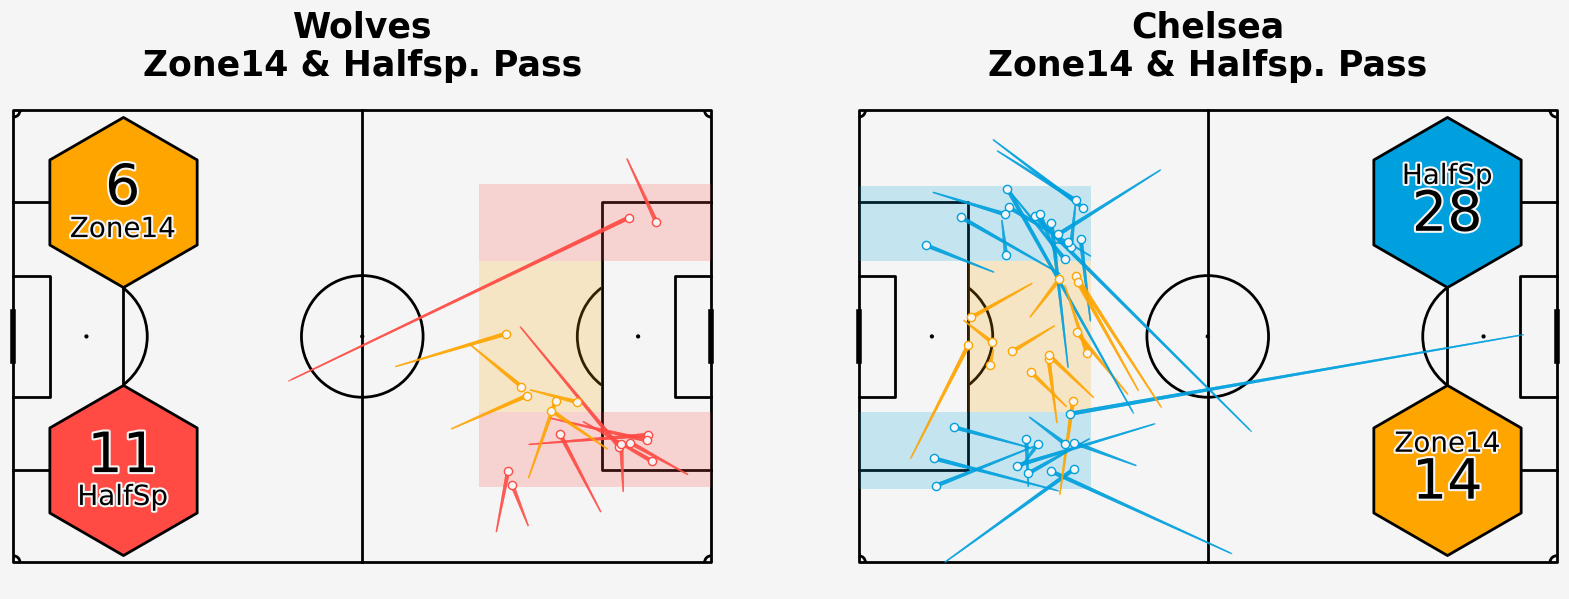

In [121]:
def zone14hs(ax, team_name, col):
    dfhp = df[(df['teamName']==team_name) & (df['type']=='Pass') & (df['outcomeType']=='Successful') & 
              (~df['qualifiers'].str.contains('CornerTaken|Freekick'))]
    
    pitch = Pitch(pitch_type='uefa', pitch_color=bg_color, line_color=line_color,  linewidth=2,
                          corner_arcs=True)
    pitch.draw(ax=ax)
    ax.set_xlim(-0.5, 105.5)
    ax.set_facecolor(bg_color)
    if team_name == ateamName:
      ax.invert_xaxis()
      ax.invert_yaxis()

    # setting the count varibale
    z14 = 0
    hs = 0
    lhs = 0
    rhs = 0

    path_eff = [path_effects.Stroke(linewidth=3, foreground=bg_color), path_effects.Normal()]
    # iterating ecah pass and according to the conditions plotting only zone14 and half spaces passes
    for index, row in dfhp.iterrows():
        if row['endX'] >= 70 and row['endX'] <= 88.54 and row['endY'] >= 22.66 and row['endY'] <= 45.32:
            pitch.lines(row['x'], row['y'], row['endX'], row['endY'], color='orange', comet=True, lw=3, zorder=3, ax=ax, alpha=0.75)
            ax.scatter(row['endX'], row['endY'], s=35, linewidth=1, color=bg_color, edgecolor='orange', zorder=4)
            z14 += 1
        if row['endX'] >= 70 and row['endY'] >= 11.33 and row['endY'] <= 22.66:
            pitch.lines(row['x'], row['y'], row['endX'], row['endY'], color=col, comet=True, lw=3, zorder=3, ax=ax, alpha=0.75)
            ax.scatter(row['endX'], row['endY'], s=35, linewidth=1, color=bg_color, edgecolor=col, zorder=4)
            hs += 1
            rhs += 1
        if row['endX'] >= 70 and row['endY'] >= 45.32 and row['endY'] <= 56.95:
            pitch.lines(row['x'], row['y'], row['endX'], row['endY'], color=col, comet=True, lw=3, zorder=3, ax=ax, alpha=0.75)
            ax.scatter(row['endX'], row['endY'], s=35, linewidth=1, color=bg_color, edgecolor=col, zorder=4)
            hs += 1
            lhs += 1

    # coloring those zones in the pitch
    y_z14 = [22.66, 22.66, 45.32, 45.32]
    x_z14 = [70, 88.54, 88.54, 70]
    ax.fill(x_z14, y_z14, 'orange', alpha=0.2, label='Zone14')

    y_rhs = [11.33, 11.33, 22.66, 22.66]
    x_rhs = [70, 105, 105, 70]
    ax.fill(x_rhs, y_rhs, col, alpha=0.2, label='HalfSpaces')

    y_lhs = [45.32, 45.32, 56.95, 56.95]
    x_lhs = [70, 105, 105, 70]
    ax.fill(x_lhs, y_lhs, col, alpha=0.2, label='HalfSpaces')

    # showing the counts in an attractive way
    z14name = "Zone14"
    hsname = "HalfSp"
    z14count = f"{z14}"
    hscount = f"{hs}"
    ax.scatter(16.46, 13.85, color=col, s=15000, edgecolor=line_color, linewidth=2, alpha=1, marker='h')
    ax.scatter(16.46, 54.15, color='orange', s=15000, edgecolor=line_color, linewidth=2, alpha=1, marker='h')
    ax.text(16.46, 13.85-4, hsname, fontsize=20, color=line_color, ha='center', va='center', path_effects=path_eff)
    ax.text(16.46, 54.15-4, z14name, fontsize=20, color=line_color, ha='center', va='center', path_effects=path_eff)
    ax.text(16.46, 13.85+2, hscount, fontsize=40, color=line_color, ha='center', va='center', path_effects=path_eff)
    ax.text(16.46, 54.15+2, z14count, fontsize=40, color=line_color, ha='center', va='center', path_effects=path_eff)

    # Headings and other texts
    if col == hcol:
      ax.set_title(f"{hteamName}\nZone14 & Halfsp. Pass", color=line_color, fontsize=25, fontweight='bold')
    else:
      ax.set_title(f"{ateamName}\nZone14 & Halfsp. Pass", color=line_color, fontsize=25, fontweight='bold')

    return {
        'Team_Name': team_name,
        'Total_Passes_Into_Zone14': z14,
        'Passes_Into_Halfspaces': hs,
        'Passes_Into_Left_Halfspaces': lhs,
        'Passes_Into_Right_Halfspaces': rhs
    }

fig,axs=plt.subplots(1,2, figsize=(20,10), facecolor=bg_color)
zonal_passing_stats_home = zone14hs(axs[0], hteamName, hcol)
zonal_passing_stats_away = zone14hs(axs[1], ateamName, acol)
zonal_passing_stats_list = []
zonal_passing_stats_list.append(zonal_passing_stats_home)
zonal_passing_stats_list.append(zonal_passing_stats_away)
zonal_passing_stats_df = pd.DataFrame(zonal_passing_stats_list)

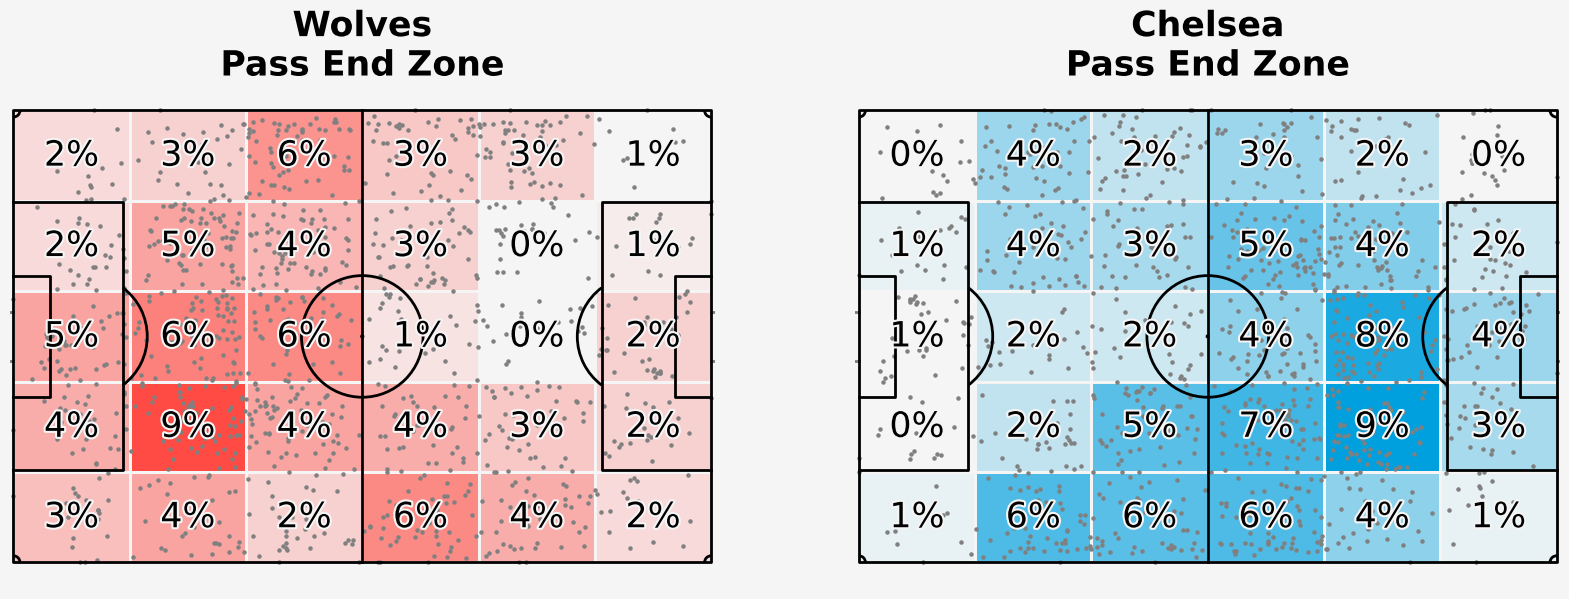

In [123]:
# setting the custom colormap
pearl_earring_cmaph = LinearSegmentedColormap.from_list("Pearl Earring - 10 colors",  [bg_color, hcol], N=20)
pearl_earring_cmapa = LinearSegmentedColormap.from_list("Pearl Earring - 10 colors",  [bg_color, acol], N=20)

path_eff = [path_effects.Stroke(linewidth=3, foreground=bg_color), path_effects.Normal()]

# Getting heatmap of all the end point of the successful Passes
def Pass_end_zone(ax, team_name, cm):
    pez = df[(df['teamName'] == team_name) & (df['type'] == 'Pass') & (df['outcomeType'] == 'Successful')]
    pitch = Pitch(pitch_type='uefa', line_color=line_color, goal_type='box', goal_alpha=.5, corner_arcs=True, line_zorder=2, pitch_color=bg_color, linewidth=2)
    pitch.draw(ax=ax)
    ax.set_xlim(-0.5, 105.5)
    if team_name == ateamName:
      ax.invert_xaxis()
      ax.invert_yaxis()

    pearl_earring_cmap = cm
    # binning the data points
    bin_statistic = pitch.bin_statistic(pez.endX, pez.endY, bins=(6, 5), normalize=True)
    pitch.heatmap(bin_statistic, ax=ax, cmap=pearl_earring_cmap, edgecolors=bg_color)
    pitch.scatter(df.endX, df.endY, c='gray', s=5, ax=ax)
    labels = pitch.label_heatmap(bin_statistic, color=line_color, fontsize=25, ax=ax, ha='center', va='center', str_format='{:.0%}', path_effects=path_eff)

    # Headings and other texts
    if team_name == hteamName:
      ax.set_title(f"{hteamName}\nPass End Zone", color=line_color, fontsize=25, fontweight='bold', path_effects=path_eff)
    else:
      ax.set_title(f"{ateamName}\nPass End Zone", color=line_color, fontsize=25, fontweight='bold', path_effects=path_eff)

fig,axs=plt.subplots(1,2, figsize=(20,10), facecolor=bg_color)
Pass_end_zone(axs[0], hteamName, pearl_earring_cmaph)
Pass_end_zone(axs[1], ateamName, pearl_earring_cmapa)

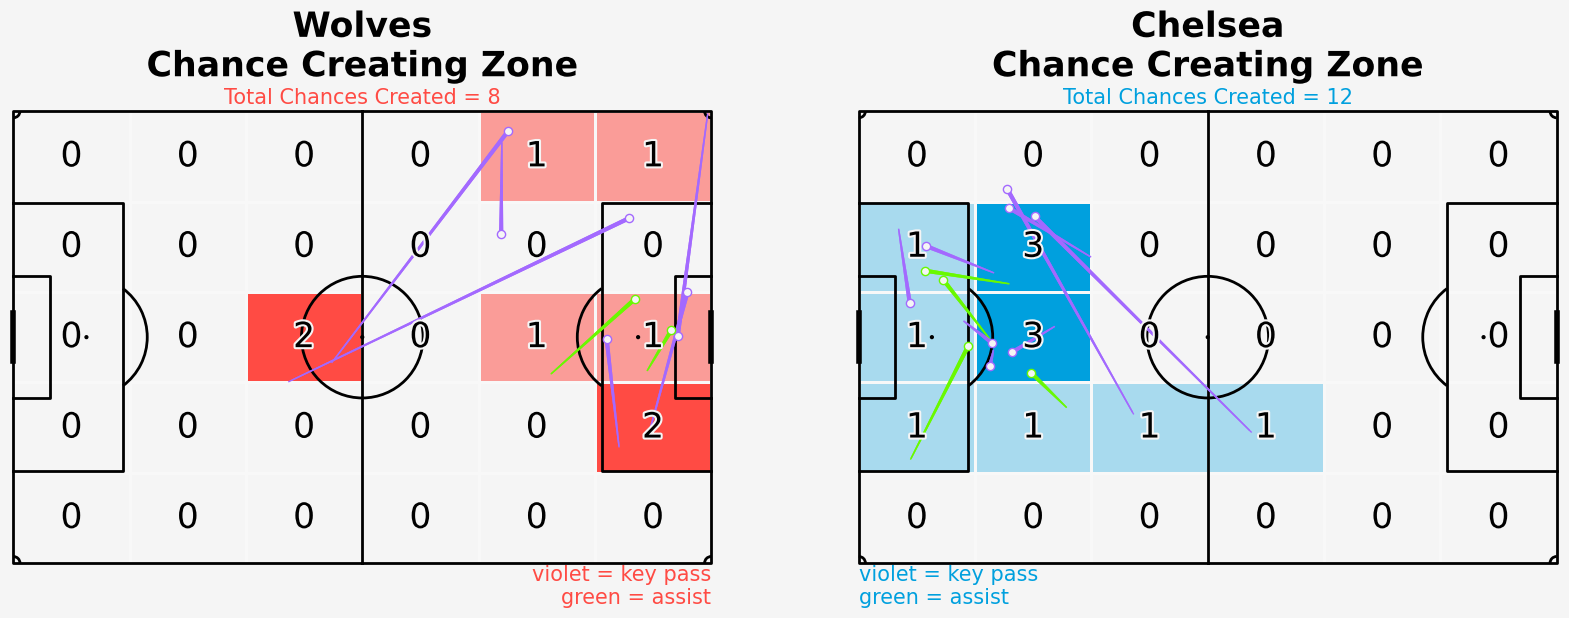

In [125]:
# setting the custom colormap
pearl_earring_cmaph = LinearSegmentedColormap.from_list("Pearl Earring - 10 colors", [bg_color, hcol], N=20)
pearl_earring_cmapa = LinearSegmentedColormap.from_list("Pearl Earring - 10 colors", [bg_color, acol], N=20)

path_eff = [path_effects.Stroke(linewidth=3, foreground=bg_color), path_effects.Normal()]

def Chance_creating_zone(ax, team_name, cm, col):
    ccp = df[(df['qualifiers'].str.contains('KeyPass')) & (df['teamName']==team_name)]
    pitch = Pitch(pitch_type='uefa', line_color=line_color, corner_arcs=True, line_zorder=2, pitch_color=bg_color, linewidth=2)
    pitch.draw(ax=ax)
    ax.set_xlim(-0.5, 105.5)
    if team_name == ateamName:
      ax.invert_xaxis()
      ax.invert_yaxis()

    cc = 0
    pearl_earring_cmap = cm
    # bin_statistic = pitch.bin_statistic_positional(df.x, df.y, statistic='count', positional='full', normalize=False)
    bin_statistic = pitch.bin_statistic(ccp.x, ccp.y, bins=(6,5), statistic='count', normalize=False)
    pitch.heatmap(bin_statistic, ax=ax, cmap=pearl_earring_cmap, edgecolors='#f8f8f8')
    # pitch.scatter(ccp.x, ccp.y, c='gray', s=5, ax=ax)
    for index, row in ccp.iterrows():
      if 'IntentionalGoalAssist' in row['qualifiers']:
        pitch.lines(row['x'], row['y'], row['endX'], row['endY'], color=green, comet=True, lw=3, zorder=3, ax=ax)
        ax.scatter(row['endX'], row['endY'], s=35, linewidth=1, color=bg_color, edgecolor=green, zorder=4)
        cc += 1
      else :
        pitch.lines(row['x'], row['y'], row['endX'], row['endY'], color=violet, comet=True, lw=3, zorder=3, ax=ax)
        ax.scatter(row['endX'], row['endY'], s=35, linewidth=1, color=bg_color, edgecolor=violet, zorder=4)
        cc += 1
    labels = pitch.label_heatmap(bin_statistic, color=line_color, fontsize=25, ax=ax, ha='center', va='center', str_format='{:.0f}', path_effects=path_eff)
    teamName = team_name

    # Headings and other texts
    if col == hcol:
      ax.text(105,-3.5, "violet = key pass\ngreen = assist", color=hcol, size=15, ha='right', va='center')
      ax.text(52.5,70, f"Total Chances Created = {cc}", color=col, fontsize=15, ha='center', va='center')
      ax.set_title(f"{hteamName}\nChance Creating Zone", color=line_color, fontsize=25, fontweight='bold', path_effects=path_eff)
    else:
      ax.text(105,71.5, "violet = key pass\ngreen = assist", color=acol, size=15, ha='left', va='center')
      ax.text(52.5,-2, f"Total Chances Created = {cc}", color=col, fontsize=15, ha='center', va='center')
      ax.set_title(f"{ateamName}\nChance Creating Zone", color=line_color, fontsize=25, fontweight='bold', path_effects=path_eff)

    return {
        'Team_Name': team_name,
        'Total_Chances_Created': cc
    }

fig,axs=plt.subplots(1,2, figsize=(20,10), facecolor=bg_color)
chance_creating_stats_home = Chance_creating_zone(axs[0], hteamName, pearl_earring_cmaph, hcol)
chance_creating_stats_away = Chance_creating_zone(axs[1], ateamName, pearl_earring_cmapa, acol)
chance_creating_stats_list = []
chance_creating_stats_list.append(chance_creating_stats_home)
chance_creating_stats_list.append(chance_creating_stats_away)
chance_creating_stats_df = pd.DataFrame(chance_creating_stats_list)

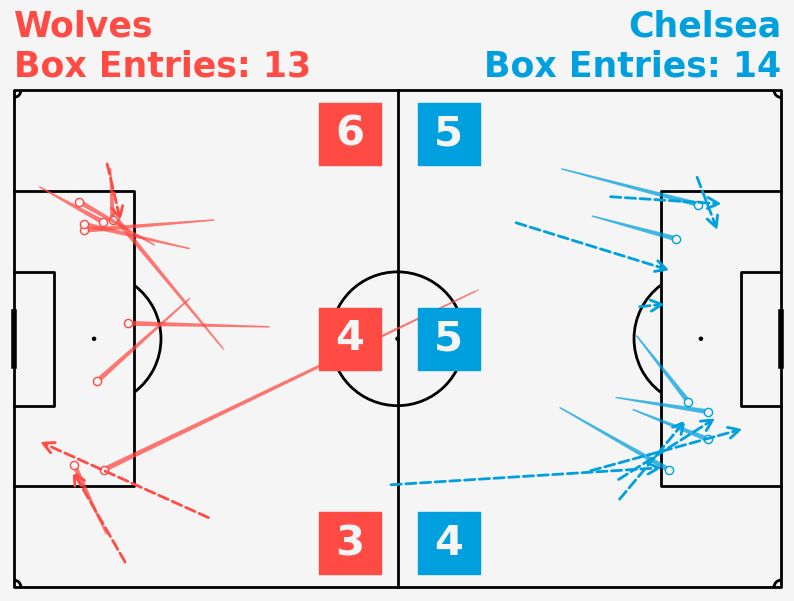

In [127]:
def box_entry(ax):
    # Box Entry means passes or carries which has started outside the Opponent Penalty Box and ended inside the Opponent Penalty Box 
    bentry = df[((df['type']=='Pass')|(df['type']=='Carry')) & (df['outcomeType']=='Successful') & (df['endX']>=88.5) &
                 ~((df['x']>=88.5) & (df['y']>=13.6) & (df['y']<=54.6)) & (df['endY']>=13.6) & (df['endY']<=54.4) &
            (~df['qualifiers'].str.contains('CornerTaken|Freekick|ThrowIn'))]
    hbentry = bentry[bentry['teamName']==hteamName]
    abentry = bentry[bentry['teamName']==ateamName]

    hrigt = hbentry[hbentry['y']<68/3]
    hcent = hbentry[(hbentry['y']>=68/3) & (hbentry['y']<=136/3)]
    hleft = hbentry[hbentry['y']>136/3]

    arigt = abentry[(abentry['y']<68/3)]
    acent = abentry[(abentry['y']>=68/3) & (abentry['y']<=136/3)]
    aleft = abentry[(abentry['y']>136/3)]

    pitch = Pitch(pitch_type='uefa', line_color=line_color, corner_arcs=True, line_zorder=2, pitch_color=bg_color, linewidth=2)
    pitch.draw(ax=ax)
    ax.set_xlim(-0.5, 105.5)
    ax.set_ylim(-0.5, 68.5)

    for index, row in bentry.iterrows():
        if row['teamName'] == ateamName:
            color = acol
            x, y, endX, endY = row['x'], row['y'], row['endX'], row['endY']
        elif row['teamName'] == hteamName:
            color = hcol
            x, y, endX, endY = 105 - row['x'], 68 - row['y'], 105 - row['endX'], 68 - row['endY']
        else:
            continue  # Skip rows that don't match either team name

        if row['type'] == 'Pass':
            pitch.lines(x, y, endX, endY, lw=3.5, comet=True, color=color, ax=ax, alpha=0.5)
            pitch.scatter(endX, endY, s=35, edgecolor=color, linewidth=1, color=bg_color, zorder=2, ax=ax)
        elif row['type'] == 'Carry':
            arrow = patches.FancyArrowPatch((x, y), (endX, endY), arrowstyle='->', color=color, zorder=4, mutation_scale=20, 
                                            alpha=1, linewidth=2, linestyle='--')
            ax.add_patch(arrow)

    
    ax.text(0, 69, f'{hteamName}\nBox Entries: {len(hbentry)}', color=hcol, fontsize=25, fontweight='bold', ha='left', va='bottom')
    ax.text(105, 69, f'{ateamName}\nBox Entries: {len(abentry)}', color=acol, fontsize=25, fontweight='bold', ha='right', va='bottom')

    ax.scatter(46, 6, s=2000, marker='s', color=hcol, zorder=3)
    ax.scatter(46, 34, s=2000, marker='s', color=hcol, zorder=3)
    ax.scatter(46, 62, s=2000, marker='s', color=hcol, zorder=3)
    ax.text(46, 6, f'{len(hleft)}', fontsize=30, fontweight='bold', color=bg_color, ha='center', va='center')
    ax.text(46, 34, f'{len(hcent)}', fontsize=30, fontweight='bold', color=bg_color, ha='center', va='center')
    ax.text(46, 62, f'{len(hrigt)}', fontsize=30, fontweight='bold', color=bg_color, ha='center', va='center')

    ax.scatter(59.5, 6, s=2000, marker='s', color=acol, zorder=3)
    ax.scatter(59.5, 34, s=2000, marker='s', color=acol, zorder=3)
    ax.scatter(59.5, 62, s=2000, marker='s', color=acol, zorder=3)
    ax.text(59.5, 6, f'{len(arigt)}', fontsize=30, fontweight='bold', color=bg_color, ha='center', va='center')
    ax.text(59.5, 34, f'{len(acent)}', fontsize=30, fontweight='bold', color=bg_color, ha='center', va='center')
    ax.text(59.5, 62, f'{len(aleft)}', fontsize=30, fontweight='bold', color=bg_color, ha='center', va='center')

    home_data = {
        'Team_Name': hteamName,
        'Total_Box_Entries': len(hbentry),
        'Box_Entry_From_Left': len(hleft),
        'Box_Entry_From_Center': len(hcent),
        'Box_Entry_From_Right': len(hrigt)
    }
    
    away_data = {
        'Team_Name': ateamName,
        'Total_Box_Entries': len(abentry),
        'Box_Entry_From_Left': len(aleft),
        'Box_Entry_From_Center': len(acent),
        'Box_Entry_From_Right': len(arigt)
    }
    
    return [home_data, away_data]

fig,ax=plt.subplots(figsize=(10,10), facecolor=bg_color)
box_entry_stats = box_entry(ax)
box_entry_stats_df = pd.DataFrame(box_entry_stats)

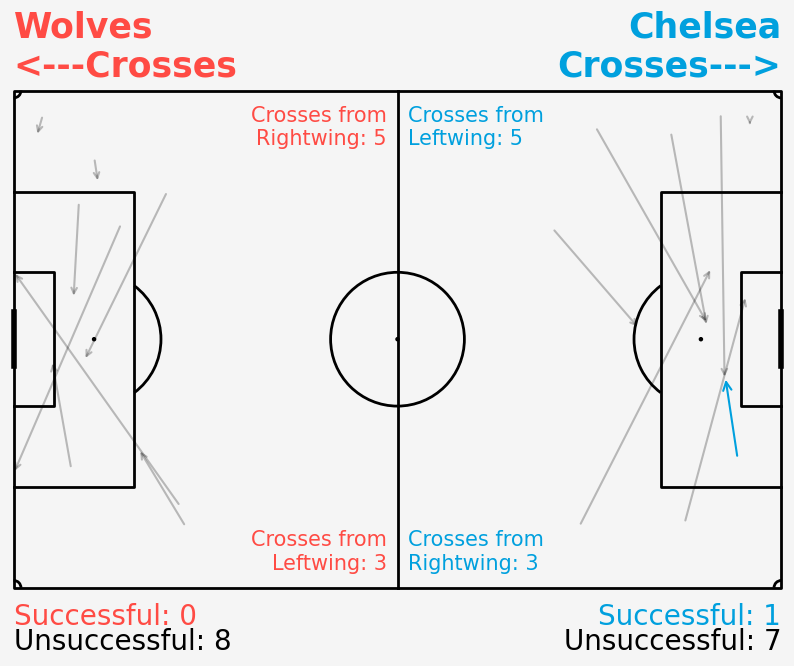

In [129]:
def Crosses(ax):
    pitch = Pitch(pitch_type='uefa', corner_arcs=True, pitch_color=bg_color, line_color=line_color, linewidth=2)
    pitch.draw(ax=ax)
    ax.set_ylim(-0.5,68.5)
    ax.set_xlim(-0.5,105.5)

    home_cross = df[(df['teamName']==hteamName) & (df['type']=='Pass') & (df['qualifiers'].str.contains('Cross')) & (~df['qualifiers'].str.contains('Corner'))]
    away_cross = df[(df['teamName']==ateamName) & (df['type']=='Pass') & (df['qualifiers'].str.contains('Cross')) & (~df['qualifiers'].str.contains('Corner'))]

    hsuc = 0
    hunsuc = 0
    asuc = 0
    aunsuc = 0

    # iterating through each pass and coloring according to successful or not
    for index, row in home_cross.iterrows():
        if row['outcomeType'] == 'Successful':
            arrow = patches.FancyArrowPatch((105-row['x'], 68-row['y']), (105-row['endX'], 68-row['endY']), arrowstyle='->', mutation_scale=15, color=hcol, linewidth=1.5, alpha=1)
            ax.add_patch(arrow)
            hsuc += 1
        else:
            arrow = patches.FancyArrowPatch((105-row['x'], 68-row['y']), (105-row['endX'], 68-row['endY']), arrowstyle='->', mutation_scale=10, color=line_color, linewidth=1.5, alpha=.25)
            ax.add_patch(arrow)
            hunsuc += 1

    for index, row in away_cross.iterrows():
        if row['outcomeType'] == 'Successful':
            arrow = patches.FancyArrowPatch((row['x'], row['y']), (row['endX'], row['endY']), arrowstyle='->', mutation_scale=15, color=acol, linewidth=1.5, alpha=1)
            ax.add_patch(arrow)
            asuc += 1
        else:
            arrow = patches.FancyArrowPatch((row['x'], row['y']), (row['endX'], row['endY']), arrowstyle='->', mutation_scale=10, color=line_color, linewidth=1.5, alpha=.25)
            ax.add_patch(arrow)
            aunsuc += 1

    # Headlines and other texts
    home_left = len(home_cross[home_cross['y']>=34])
    home_right = len(home_cross[home_cross['y']<34])
    away_left = len(away_cross[away_cross['y']>=34])
    away_right = len(away_cross[away_cross['y']<34])

    ax.text(51, 2, f"Crosses from\nLeftwing: {home_left}", color=hcol, fontsize=15, va='bottom', ha='right')
    ax.text(51, 66, f"Crosses from\nRightwing: {home_right}", color=hcol, fontsize=15, va='top', ha='right')
    ax.text(54, 66, f"Crosses from\nLeftwing: {away_left}", color=acol, fontsize=15, va='top', ha='left')
    ax.text(54, 2, f"Crosses from\nRightwing: {away_right}", color=acol, fontsize=15, va='bottom', ha='left')

    ax.text(0,-2, f"Successful: {hsuc}", color=hcol, fontsize=20, ha='left', va='top')
    ax.text(0,-5.5, f"Unsuccessful: {hunsuc}", color=line_color, fontsize=20, ha='left', va='top')
    ax.text(105,-2, f"Successful: {asuc}", color=acol, fontsize=20, ha='right', va='top')
    ax.text(105,-5.5, f"Unsuccessful: {aunsuc}", color=line_color, fontsize=20, ha='right', va='top')

    ax.text(0, 70, f"{hteamName}\n<---Crosses", color=hcol, size=25, ha='left', fontweight='bold')
    ax.text(105, 70, f"{ateamName}\nCrosses--->", color=acol, size=25, ha='right', fontweight='bold')

    home_data = {
        'Team_Name': hteamName,
        'Total_Cross': hsuc + hunsuc,
        'Successful_Cross': hsuc,
        'Unsuccessful_Cross': hunsuc,
        'Cross_From_LeftWing': home_left,
        'Cross_From_RightWing': home_right
    }
    
    away_data = {
        'Team_Name': ateamName,
        'Total_Cross': asuc + aunsuc,
        'Successful_Cross': asuc,
        'Unsuccessful_Cross': aunsuc,
        'Cross_From_LeftWing': away_left,
        'Cross_From_RightWing': away_right
    }
    
    return [home_data, away_data]

fig,ax=plt.subplots(figsize=(10,10), facecolor=bg_color)
cross_stats = Crosses(ax)
cross_stats_df = pd.DataFrame(cross_stats)

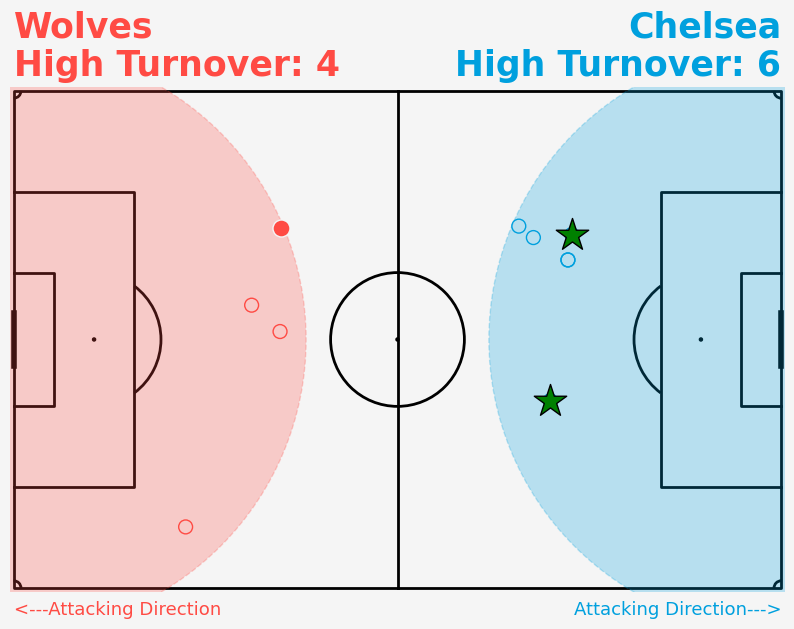

In [131]:
def HighTO(ax):
    pitch = Pitch(pitch_type='uefa', corner_arcs=True, pitch_color=bg_color, line_color=line_color, linewidth=2)
    pitch.draw(ax=ax)
    ax.set_ylim(-0.5,68.5)
    ax.set_xlim(-0.5,105.5)

    # High Turnover means any sequence which starts in open play and within 40 metres of the opponent's goal 
    highTO = df
    highTO['Distance'] = ((highTO['x'] - 105)**2 + (highTO['y'] - 34)**2)**0.5

    # HTO which led to Goal for away team
    agoal_count = 0
    # Iterate through the DataFrame
    for i in range(len(highTO)):
        if ((highTO.loc[i, 'type'] in ['BallRecovery', 'Interception']) and 
            (highTO.loc[i, 'teamName'] == ateamName) and 
            (highTO.loc[i, 'Distance'] <= 40)):
            
            possession_id = highTO.loc[i, 'possession_id']
            
            # Check the following rows within the same possession
            j = i + 1
            while j < len(highTO) and highTO.loc[j, 'possession_id'] == possession_id and highTO.loc[j, 'teamName']==ateamName:
                if highTO.loc[j, 'type'] == 'Goal' and highTO.loc[j, 'teamName']==ateamName:
                    ax.scatter(highTO.loc[i, 'x'],highTO.loc[i, 'y'], s=600, marker='*', color='green', edgecolor='k', zorder=3)
                    agoal_count += 1
                    break
                j += 1

    # HTO which led to Shot for away team
    ashot_count = 0
    # Iterate through the DataFrame
    for i in range(len(highTO)):
        if ((highTO.loc[i, 'type'] in ['BallRecovery', 'Interception']) and 
            (highTO.loc[i, 'teamName'] == ateamName) and 
            (highTO.loc[i, 'Distance'] <= 40)):
            
            possession_id = highTO.loc[i, 'possession_id']
            
            # Check the following rows within the same possession
            j = i + 1
            while j < len(highTO) and highTO.loc[j, 'possession_id'] == possession_id and highTO.loc[j, 'teamName']==ateamName:
                if ('Shot' in highTO.loc[j, 'type']) and (highTO.loc[j, 'teamName']==ateamName):
                    ax.scatter(highTO.loc[i, 'x'],highTO.loc[i, 'y'], s=150, color=acol, edgecolor=bg_color, zorder=2)
                    ashot_count += 1
                    break
                j += 1
    
    # other HTO for away team
    aht_count = 0
    p_list = []
    # Iterate through the DataFrame
    for i in range(len(highTO)):
        if ((highTO.loc[i, 'type'] in ['BallRecovery', 'Interception']) and 
            (highTO.loc[i, 'teamName'] == ateamName) and 
            (highTO.loc[i, 'Distance'] <= 40)):
            
            # Check the following rows
            j = i + 1
            if ((highTO.loc[j, 'teamName']==ateamName) and
                (highTO.loc[j, 'type']!='Dispossessed') and (highTO.loc[j, 'type']!='OffsidePass')):
                ax.scatter(highTO.loc[i, 'x'],highTO.loc[i, 'y'], s=100, color='None', edgecolor=acol)
                aht_count += 1
                p_list.append(highTO.loc[i, 'shortName'])

    # HTO which led to Goal for home team
    hgoal_count = 0
    # Iterate through the DataFrame
    for i in range(len(highTO)):
        if ((highTO.loc[i, 'type'] in ['BallRecovery', 'Interception']) and 
            (highTO.loc[i, 'teamName'] == hteamName) and 
            (highTO.loc[i, 'Distance'] <= 40)):
            
            possession_id = highTO.loc[i, 'possession_id']
            
            # Check the following rows within the same possession
            j = i + 1
            while j < len(highTO) and highTO.loc[j, 'possession_id'] == possession_id and highTO.loc[j, 'teamName']==hteamName:
                if highTO.loc[j, 'type'] == 'Goal' and highTO.loc[j, 'teamName']==hteamName:
                    ax.scatter(105-highTO.loc[i, 'x'],68-highTO.loc[i, 'y'], s=600, marker='*', color='green', edgecolor='k', zorder=3)
                    hgoal_count += 1
                    break
                j += 1

    # HTO which led to Shot for home team
    hshot_count = 0
    # Iterate through the DataFrame
    for i in range(len(highTO)):
        if ((highTO.loc[i, 'type'] in ['BallRecovery', 'Interception']) and 
            (highTO.loc[i, 'teamName'] == hteamName) and 
            (highTO.loc[i, 'Distance'] <= 40)):
            
            possession_id = highTO.loc[i, 'possession_id']
            
            # Check the following rows within the same possession
            j = i + 1
            while j < len(highTO) and highTO.loc[j, 'possession_id'] == possession_id and highTO.loc[j, 'teamName']==hteamName:
                if ('Shot' in highTO.loc[j, 'type']) and (highTO.loc[j, 'teamName']==hteamName):
                    ax.scatter(105-highTO.loc[i, 'x'],68-highTO.loc[i, 'y'], s=150, color=hcol, edgecolor=bg_color, zorder=2)
                    hshot_count += 1
                    break
                j += 1

    # other HTO for home team
    hht_count = 0
    p_list = []
    # Iterate through the DataFrame
    for i in range(len(highTO)):
        if ((highTO.loc[i, 'type'] in ['BallRecovery', 'Interception']) and 
            (highTO.loc[i, 'teamName'] == hteamName) and 
            (highTO.loc[i, 'Distance'] <= 40)):
            
            # Check the following rows
            j = i + 1
            if ((highTO.loc[j, 'teamName']==hteamName) and
                (highTO.loc[j, 'type']!='Dispossessed') and (highTO.loc[j, 'type']!='OffsidePass')):
                ax.scatter(105-highTO.loc[i, 'x'],68-highTO.loc[i, 'y'], s=100, color='None', edgecolor=hcol)
                hht_count += 1
                p_list.append(highTO.loc[i, 'shortName'])

    # Plotting the half circle
    left_circle = plt.Circle((0,34), 40, color=hcol, fill=True, alpha=0.25, linestyle='dashed')
    ax.add_artist(left_circle)
    right_circle = plt.Circle((105,34), 40, color=acol, fill=True, alpha=0.25, linestyle='dashed')
    ax.add_artist(right_circle)
    # Set the aspect ratio to be equal
    ax.set_aspect('equal', adjustable='box')
    # Headlines and other texts
    ax.text(0, 70, f"{hteamName}\nHigh Turnover: {hht_count}", color=hcol, size=25, ha='left', fontweight='bold')
    ax.text(105, 70, f"{ateamName}\nHigh Turnover: {aht_count}", color=acol, size=25, ha='right', fontweight='bold')
    ax.text(0,  -3, '<---Attacking Direction', color=hcol, fontsize=13, ha='left', va='center')
    ax.text(105,-3, 'Attacking Direction--->', color=acol, fontsize=13, ha='right', va='center')

    home_data = {
        'Team_Name': hteamName,
        'Total_High_Turnovers': hht_count,
        'Shot_Ending_High_Turnovers': hshot_count,
        'Goal_Ending_High_Turnovers': hgoal_count,
        'Opponent_Team_Name': ateamName
    }
    
    away_data = {
        'Team_Name': ateamName,
        'Total_High_Turnovers': aht_count,
        'Shot_Ending_High_Turnovers': ashot_count,
        'Goal_Ending_High_Turnovers': agoal_count,
        'Opponent_Team_Name': hteamName
    }
    
    return [home_data, away_data]

fig,ax=plt.subplots(figsize=(10,10), facecolor=bg_color)
high_turnover_stats = HighTO(ax)
high_turnover_stats_df = pd.DataFrame(high_turnover_stats)

C:\Users\kevin\AppData\Local\Temp\ipykernel_12360\974693769.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['x'] = 105-df2['x']
C:\Users\kevin\AppData\Local\Temp\ipykernel_12360\974693769.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['y'] =  68-df2['y']


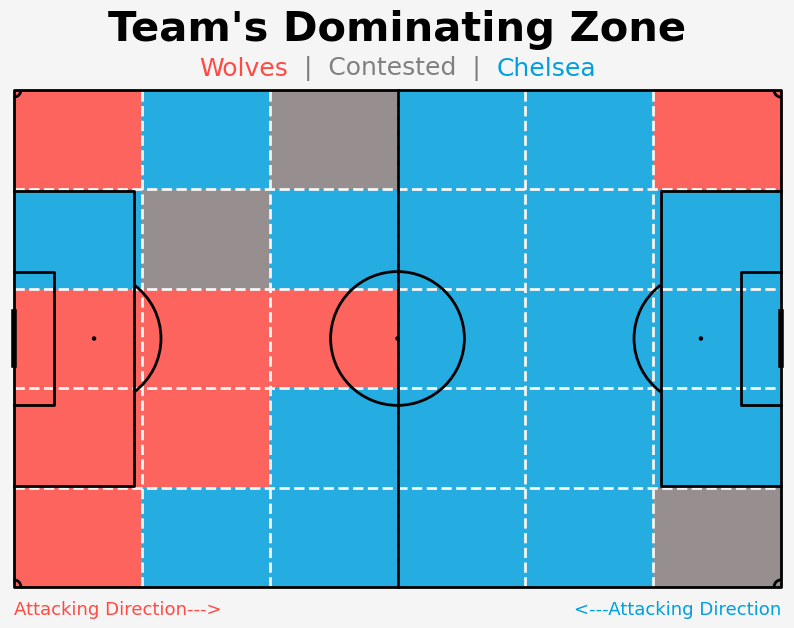

In [133]:
def plot_congestion(ax):
    # Comparing open play touches of both teams in each zones of the pitch, if more than 55% touches for a team it will be coloured of that team, otherwise gray to represent contested
    pcmap = LinearSegmentedColormap.from_list("Pearl Earring - 10 colors",  [acol, 'gray', hcol], N=20)
    df1 = df[(df['teamName']==hteamName) & (df['isTouch']==1) & (~df['qualifiers'].str.contains('CornerTaken|Freekick|ThrowIn'))]
    df2 = df[(df['teamName']==ateamName) & (df['isTouch']==1) & (~df['qualifiers'].str.contains('CornerTaken|Freekick|ThrowIn'))]
    df2['x'] = 105-df2['x']
    df2['y'] =  68-df2['y']
    pitch = Pitch(pitch_type='uefa', corner_arcs=True, pitch_color=bg_color, line_color=line_color, linewidth=2, line_zorder=6)
    pitch.draw(ax=ax)
    ax.set_ylim(-0.5,68.5)
    ax.set_xlim(-0.5,105.5)

    bin_statistic1 = pitch.bin_statistic(df1.x, df1.y, bins=(6,5), statistic='count', normalize=False)
    bin_statistic2 = pitch.bin_statistic(df2.x, df2.y, bins=(6,5), statistic='count', normalize=False)

    # Assuming 'cx' and 'cy' are as follows:
    cx = np.array([[ 8.75, 26.25, 43.75, 61.25, 78.75, 96.25],
               [ 8.75, 26.25, 43.75, 61.25, 78.75, 96.25],
               [ 8.75, 26.25, 43.75, 61.25, 78.75, 96.25],
               [ 8.75, 26.25, 43.75, 61.25, 78.75, 96.25],
               [ 8.75, 26.25, 43.75, 61.25, 78.75, 96.25]])

    cy = np.array([[61.2, 61.2, 61.2, 61.2, 61.2, 61.2],
               [47.6, 47.6, 47.6, 47.6, 47.6, 47.6],
               [34.0, 34.0, 34.0, 34.0, 34.0, 34.0],
               [20.4, 20.4, 20.4, 20.4, 20.4, 20.4],
               [ 6.8,  6.8,  6.8,  6.8,  6.8,  6.8]])

    # Flatten the arrays
    cx_flat = cx.flatten()
    cy_flat = cy.flatten()

    # Create a DataFrame
    df_cong = pd.DataFrame({'cx': cx_flat, 'cy': cy_flat})

    hd_values = []
    # Loop through the 2D arrays
    for i in range(bin_statistic1['statistic'].shape[0]):
        for j in range(bin_statistic1['statistic'].shape[1]):
            stat1 = bin_statistic1['statistic'][i, j]
            stat2 = bin_statistic2['statistic'][i, j]
        
            if (stat1 / (stat1 + stat2)) > 0.55:
                hd_values.append(1)
            elif (stat1 / (stat1 + stat2)) < 0.45:
                hd_values.append(0)
            else:
                hd_values.append(0.5)

    df_cong['hd']=hd_values
    bin_stat = pitch.bin_statistic(df_cong.cx, df_cong.cy, bins=(6,5), values=df_cong['hd'], statistic='sum', normalize=False)
    pitch.heatmap(bin_stat, ax=ax, cmap=pcmap, edgecolors='#000000', lw=0, zorder=3, alpha=0.85)

    ax_text(52.5, 71, s=f"<{hteamName}>  |  Contested  |  <{ateamName}>", highlight_textprops=[{'color':hcol}, {'color':acol}],
            color='gray', fontsize=18, ha='center', va='center', ax=ax)
    ax.set_title("Team's Dominating Zone", color=line_color, fontsize=30, fontweight='bold', y=1.075)
    ax.text(0,  -3, 'Attacking Direction--->', color=hcol, fontsize=13, ha='left', va='center')
    ax.text(105,-3, '<---Attacking Direction', color=acol, fontsize=13, ha='right', va='center')

    ax.vlines(1*(105/6), ymin=0, ymax=68, color=bg_color, lw=2, ls='--', zorder=5)
    ax.vlines(2*(105/6), ymin=0, ymax=68, color=bg_color, lw=2, ls='--', zorder=5)
    ax.vlines(3*(105/6), ymin=0, ymax=68, color=bg_color, lw=2, ls='--', zorder=5)
    ax.vlines(4*(105/6), ymin=0, ymax=68, color=bg_color, lw=2, ls='--', zorder=5)
    ax.vlines(5*(105/6), ymin=0, ymax=68, color=bg_color, lw=2, ls='--', zorder=5)

    ax.hlines(1*(68/5), xmin=0, xmax=105, color=bg_color, lw=2, ls='--', zorder=5)
    ax.hlines(2*(68/5), xmin=0, xmax=105, color=bg_color, lw=2, ls='--', zorder=5)
    ax.hlines(3*(68/5), xmin=0, xmax=105, color=bg_color, lw=2, ls='--', zorder=5)
    ax.hlines(4*(68/5), xmin=0, xmax=105, color=bg_color, lw=2, ls='--', zorder=5)
    
    return

fig,ax=plt.subplots(figsize=(10,10), facecolor=bg_color)
plot_congestion(ax)

C:\Users\kevin\AppData\Local\Temp\ipykernel_12360\2601374328.py:100: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_passes_df['pass_or_carry_angle'] = team_passes_df['pass_or_carry_angle'].abs()
C:\Users\kevin\AppData\Local\Temp\ipykernel_12360\3281878704.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hShotsdf['goalMouthZ'] = hShotsdf['goalMouthZ']*0.75
C:\Users\kevin\AppData\Local\Temp\ipykernel_12360\3281878704.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a

URLError: <urlopen error [WinError 3] The system cannot find the path specified: 'D:\\FData\\club_teams_logo\\all_league - Copy\\Wolves.html'>

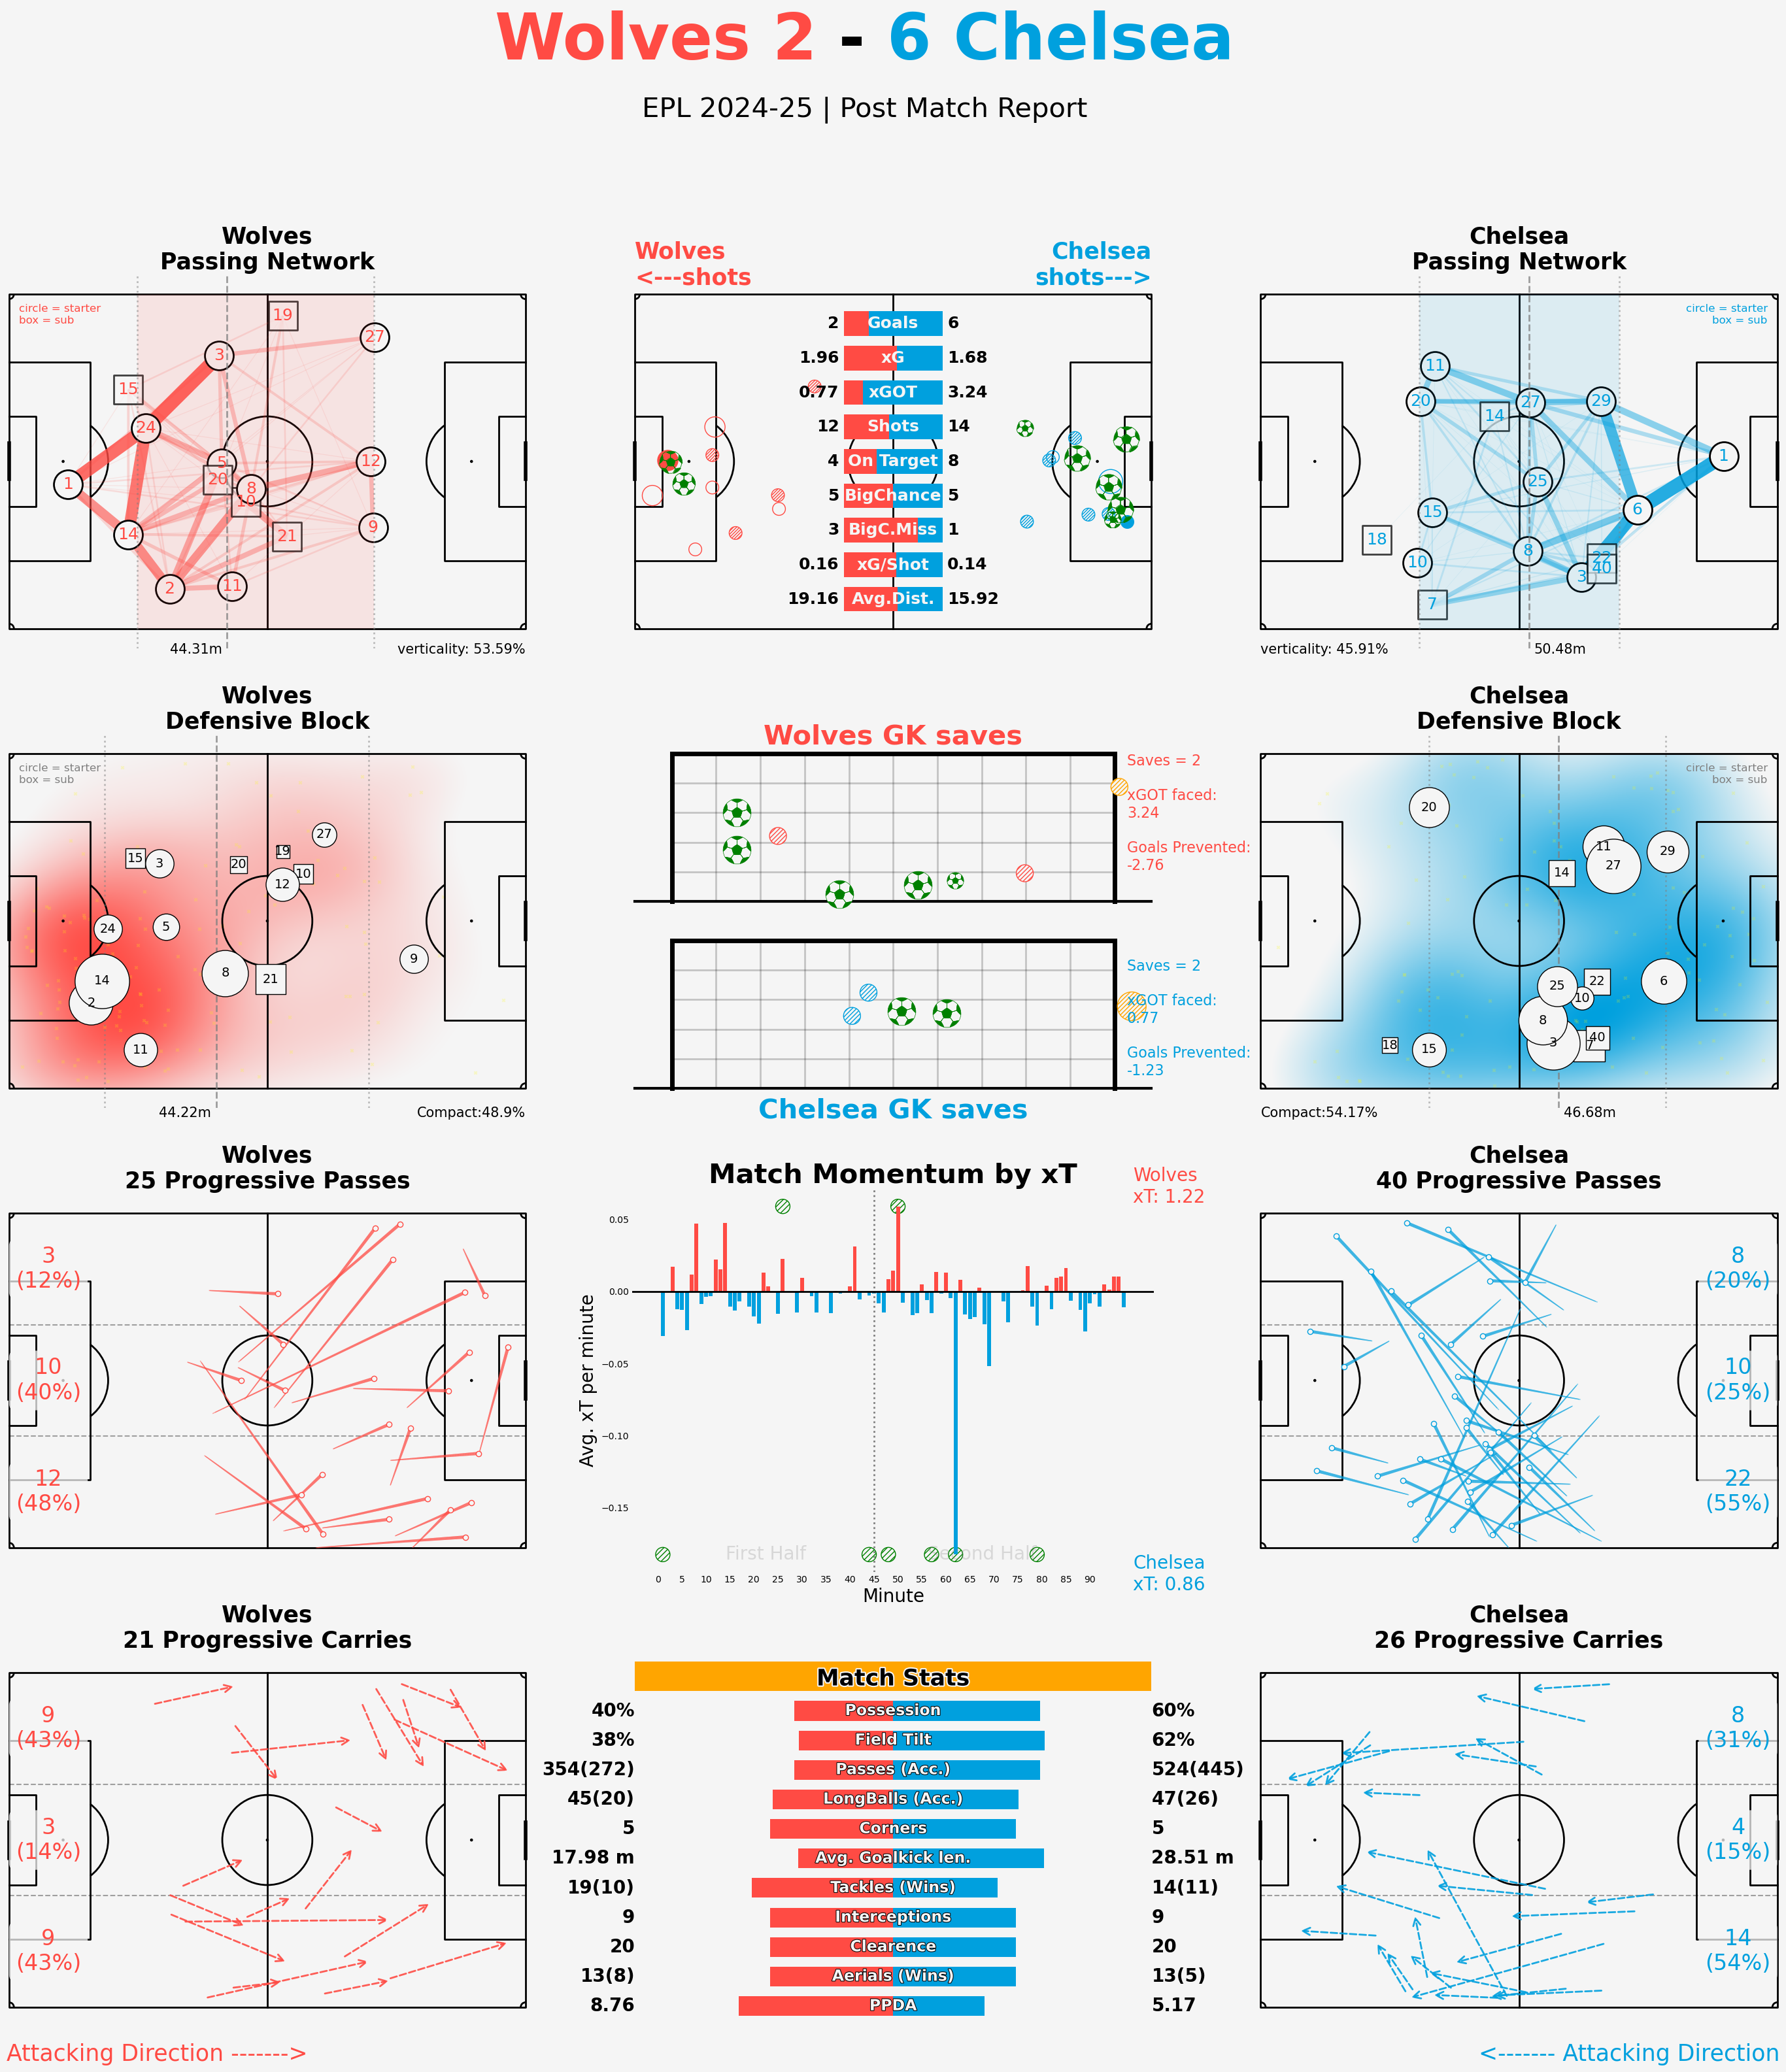

In [135]:
fig, axs = plt.subplots(4,3, figsize=(35,35), facecolor=bg_color)

pass_network_stats_home = pass_network_visualization(axs[0,0], home_passes_between_df, home_average_locs_and_count_df, hcol, hteamName)
shooting_stats = plot_shotmap(axs[0,1])
pass_network_stats_away = pass_network_visualization(axs[0,2], away_passes_between_df, away_average_locs_and_count_df, acol, ateamName)

defensive_block_stats_home = defensive_block(axs[1,0], defensive_home_average_locs_and_count_df, hteamName, hcol)
goalkeeping_stats = plot_goalPost(axs[1,1])
defensive_block_stats_away = defensive_block(axs[1,2], defensive_away_average_locs_and_count_df, ateamName, acol)

Progressvie_Passes_Stats_home = draw_progressive_pass_map(axs[2,0], hteamName, hcol)
xT_stats = plot_Momentum(axs[2,1])
Progressvie_Passes_Stats_away = draw_progressive_pass_map(axs[2,2], ateamName, acol)

Progressvie_Carries_Stats_home = draw_progressive_carry_map(axs[3,0], hteamName, hcol)
general_match_stats = plotting_match_stats(axs[3,1])
Progressvie_Carries_Stats_away = draw_progressive_carry_map(axs[3,2], ateamName, acol)

# Heading
highlight_text = [{'color':hcol}, {'color':acol}]
fig_text(0.5, 0.98, f"<{hteamName} {hgoal_count}> - <{agoal_count} {ateamName}>", color=line_color, fontsize=70, fontweight='bold',
            highlight_textprops=highlight_text, ha='center', va='center', ax=fig)

# Subtitles
fig.text(0.5, 0.95, f"EPL 2024-25 | Post Match Report", color=line_color, fontsize=30, ha='center', va='center')

fig.text(0.125,0.1, 'Attacking Direction ------->', color=hcol, fontsize=25, ha='left', va='center')
fig.text(0.9,0.1, '<------- Attacking Direction', color=acol, fontsize=25, ha='right', va='center')

# Plotting Team's Logo
# Here I have choosen a very complicated process, you may know better how to plot easily
# I download any team's png logo from google and then save that file as .html, then open that html file and copy paste the url here

# himage_url = himage_url.replace(' ', '%20')
himage = urlopen(f"file:///D:/FData/club_teams_logo/all_league%20-%20Copy/{hteamName}.html")
himage = Image.open(himage)
ax_himage = add_image(himage, fig, left=0.125, bottom=0.94, width=0.05, height=0.05)

# aimage_url = aimage_url.replace(' ', '%20')
aimage = urlopen(f"file:///D:/FData/club_teams_logo/all_league%20-%20Copy/{ateamName}.html")
aimage = Image.open(aimage)
ax_aimage = add_image(aimage, fig, left=0.85, bottom=0.94, width=0.05, height=0.05)

# Saving the final figure
# fig.savefig(f"D:\\FData\\LaLiga_2024_25\\CSV_FIles\\MatchReports\\Team\\GW1\\{file_header}_Match_Report_1.png", bbox_inches='tight')

C:\Users\kevin\AppData\Local\Temp\ipykernel_12360\974693769.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['x'] = 105-df2['x']
C:\Users\kevin\AppData\Local\Temp\ipykernel_12360\974693769.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['y'] =  68-df2['y']


URLError: <urlopen error [WinError 3] The system cannot find the path specified: 'D:\\FData\\club_teams_logo\\all_league - Copy\\Wolves.html'>

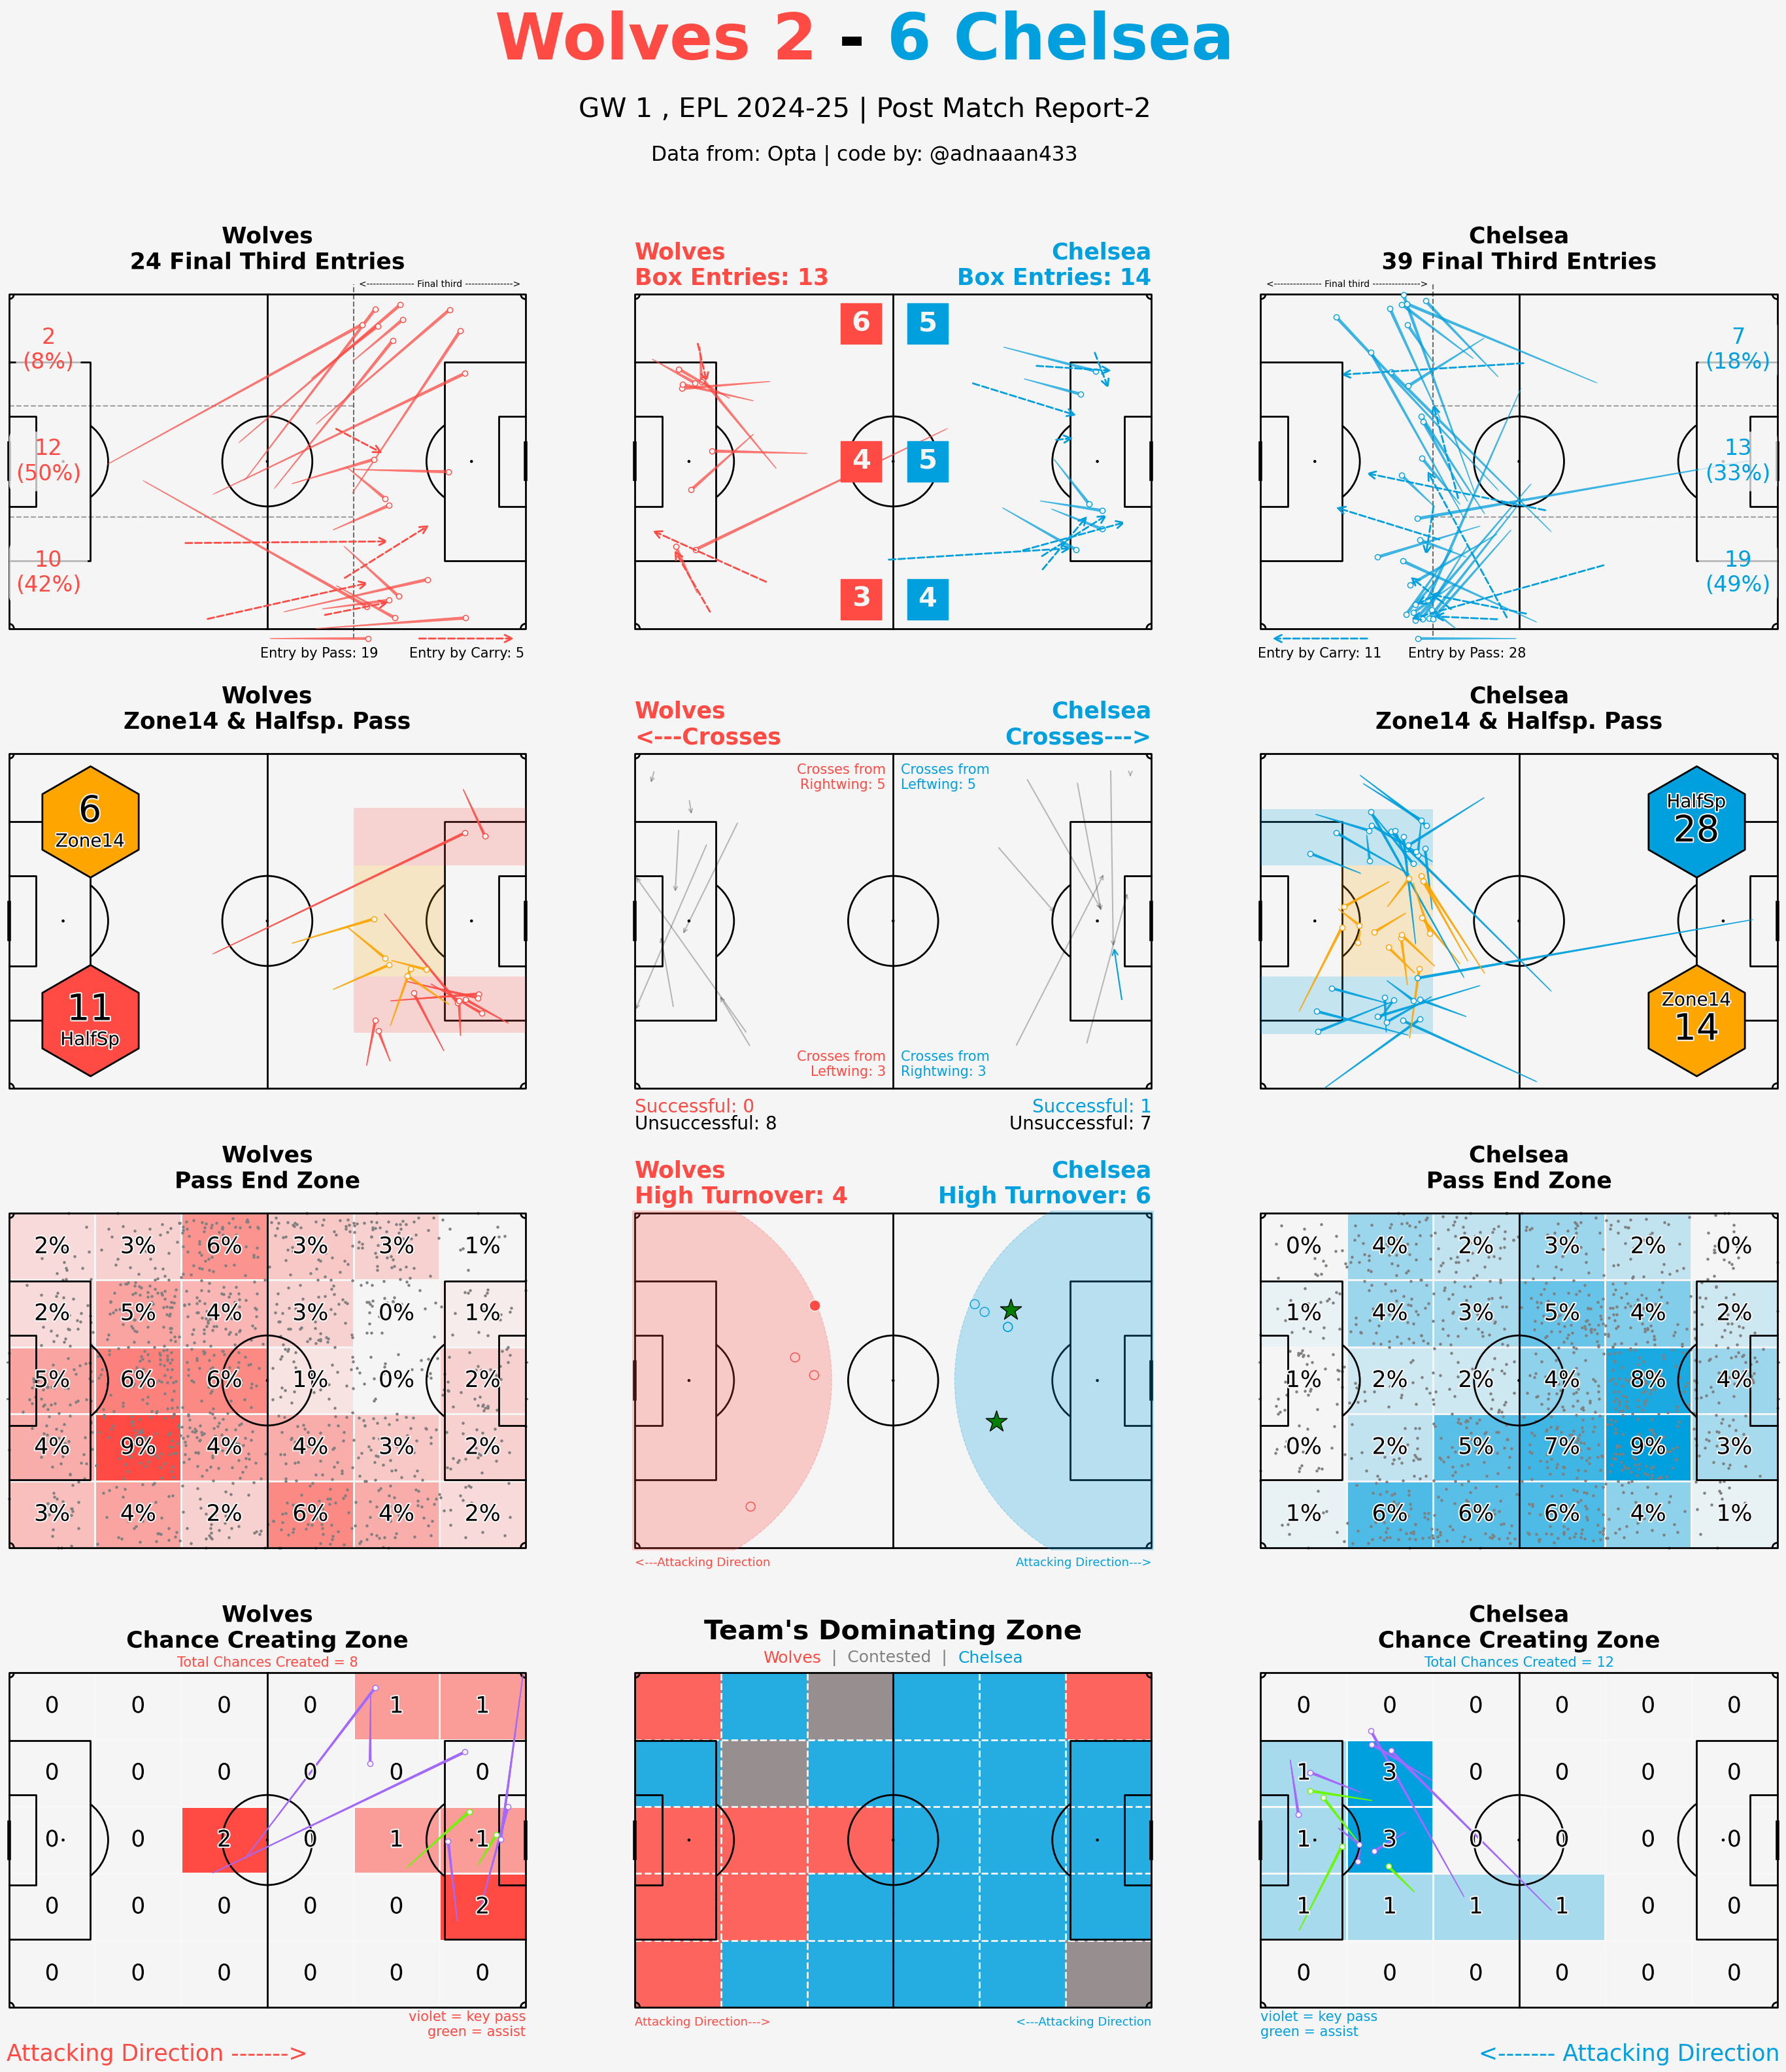

In [137]:
fig, axs = plt.subplots(4,3, figsize=(35,35), facecolor=bg_color)

final_third_entry_stats_home = Final_third_entry(axs[0,0], hteamName, hcol)
box_entry_stats = box_entry(axs[0,1])
final_third_entry_stats_away = Final_third_entry(axs[0,2], ateamName, acol)

zonal_passing_stats_home = zone14hs(axs[1,0], hteamName, hcol)
cross_stats = Crosses(axs[1,1])
zonal_passing_stats_away = zone14hs(axs[1,2], ateamName, acol)

Pass_end_zone(axs[2,0], hteamName, pearl_earring_cmaph)
high_turnover_stats = HighTO(axs[2,1])
Pass_end_zone(axs[2,2], ateamName, pearl_earring_cmapa)

chance_creating_stats_home = Chance_creating_zone(axs[3,0], hteamName, pearl_earring_cmaph, hcol)
plot_congestion(axs[3,1])
chance_creating_stats_away = Chance_creating_zone(axs[3,2], ateamName, pearl_earring_cmapa, acol)

# Heading
highlight_text = [{'color':hcol}, {'color':acol}]
fig_text(0.5, 0.98, f"<{hteamName} {hgoal_count}> - <{agoal_count} {ateamName}>", color=line_color, fontsize=70, fontweight='bold',
            highlight_textprops=highlight_text, ha='center', va='center', ax=fig)

# Subtitles
fig.text(0.5, 0.95, f"GW 1 , EPL 2024-25 | Post Match Report-2", color=line_color, fontsize=30, ha='center', va='center')
fig.text(0.5, 0.93, f"Data from: Opta | code by: @adnaaan433", color=line_color, fontsize=22.5, ha='center', va='center')

fig.text(0.125,0.1, 'Attacking Direction ------->', color=hcol, fontsize=25, ha='left', va='center')
fig.text(0.9,0.1, '<------- Attacking Direction', color=acol, fontsize=25, ha='right', va='center')

# Plotting Team's Logo
# Here I have choosen a very complicated process, you may know better how to plot easily
# I download any team's png logo from google and then save that file as .html, then open that html file and copy paste the url here

# himage_url = himage_url.replace(' ', '%20')
himage = urlopen(f"file:///D:/FData/club_teams_logo/all_league%20-%20Copy/{hteamName}.html")
himage = Image.open(himage)
ax_himage = add_image(himage, fig, left=0.125, bottom=0.94, width=0.05, height=0.05)

# aimage_url = aimage_url.replace(' ', '%20')
aimage = urlopen(f"file:///D:/FData/club_teams_logo/all_league%20-%20Copy/{ateamName}.html")
aimage = Image.open(aimage)
ax_aimage = add_image(aimage, fig, left=0.85, bottom=0.94, width=0.05, height=0.05)

# Saving the final Figure
# fig.savefig(f"D:\\FData\\LaLiga_2024_25\\CSV_FIles\\MatchReports\\Team\\GW1\\{file_header}_Match_Report_2.png", bbox_inches='tight')